##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset

This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

   16384/13568290 [..............................] - ETA: 0s

 4202496/13568290 [========>.....................] - ETA: 0s

 8396800/13568290 [=================>............] - ETA: 0s

13574144/13568290 [==============================] - 1s 0us/step


13582336/13568290 [==============================] - 1s 0us/step


This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [4]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time:

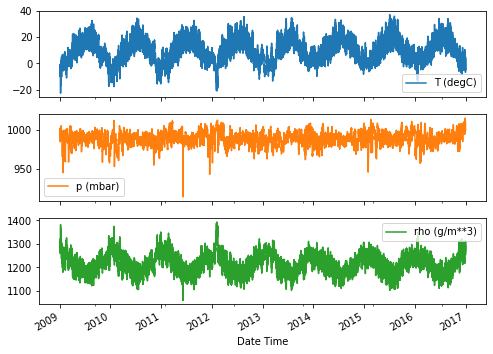

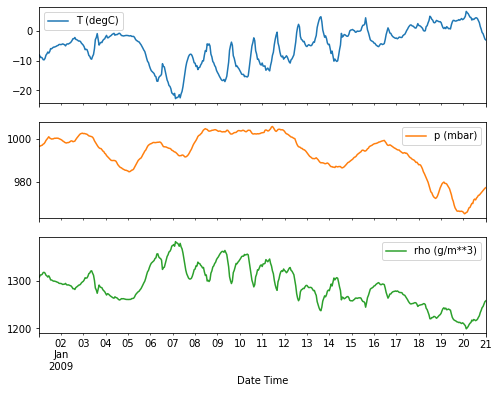

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next, look at the statistics of the dataset:

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity (`wv (m/s)`) and the maximum value (`max. wv (m/s)`) columns. This `-9999` is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than zero (`>=0`). Replace it with zeros:

In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model, it's important to understand your data and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

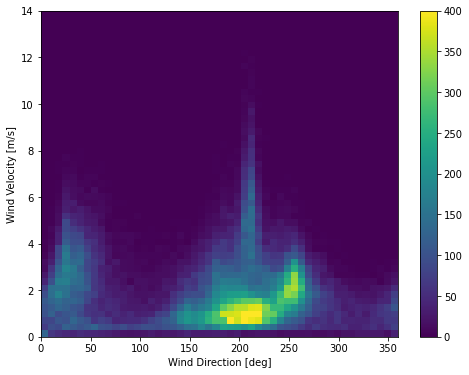

In [9]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret:

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

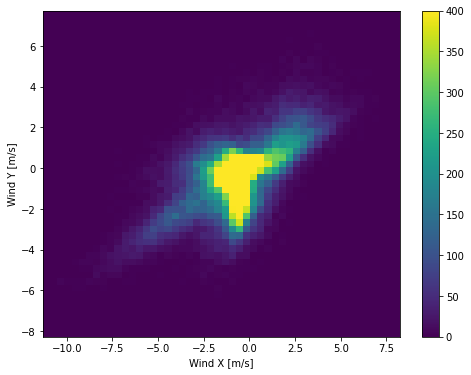

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly, the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

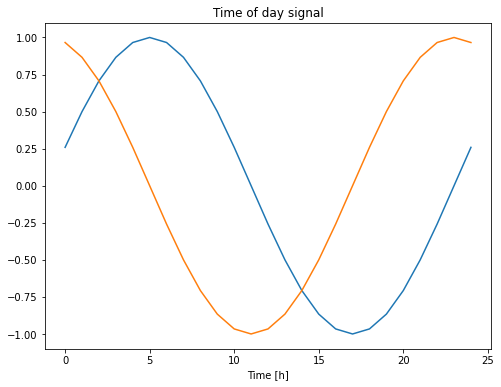

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you don't have that information, you can determine which frequencies are important by extracting features with <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a>. To check the assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:


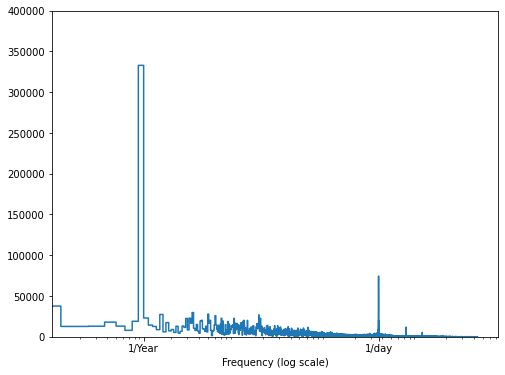

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

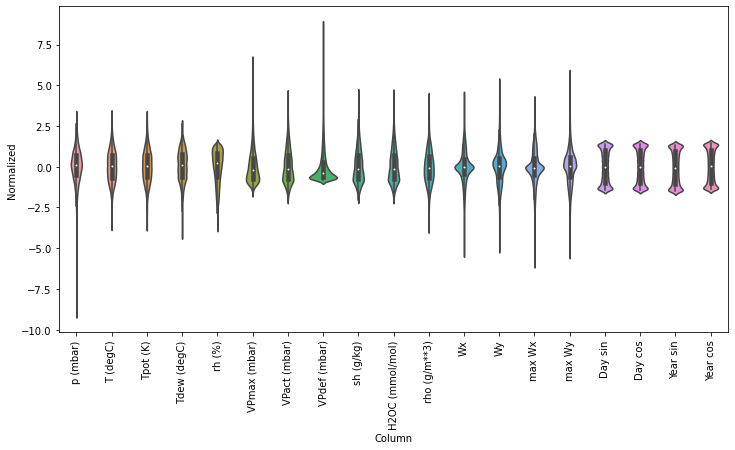

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](images/raw_window_24h.png)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [23]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

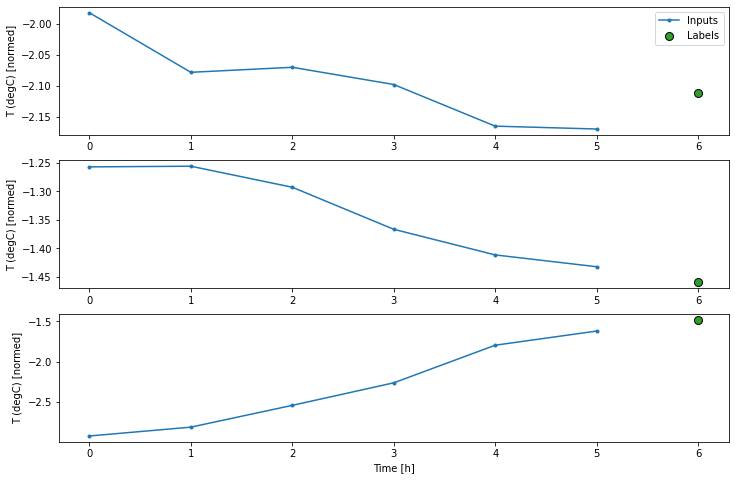

In [26]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

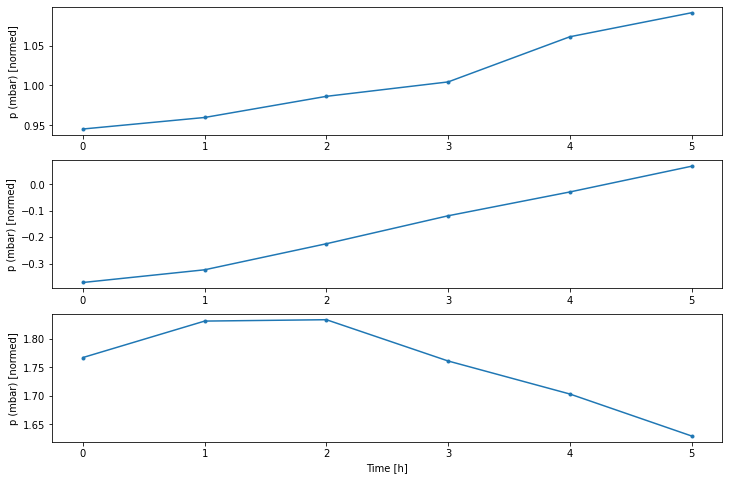

In [27]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [30]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [31]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature. 

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [34]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [35]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 1:15 - loss: 0.0092 - mean_absolute_error: 0.0682

 29/439 [>.............................] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0731  

 58/439 [==>...........................] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0734

 86/439 [====>.........................] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0751

114/439 [======>.......................] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0765

139/439 [========>.....................] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0764

167/439 [==========>...................] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0771

195/439 [============>.................] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0782

224/439 [==============>...............] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0787

253/439 [================>.............] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0784

281/439 [==================>...........] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0785

307/439 [===================>..........] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0784

330/439 [=====================>........] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0782

356/439 [=======================>......] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0779

383/439 [=========================>....] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0779

409/439 [==========================>...] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0783

439/439 [==============================] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0785

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](images/last_window.png)

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

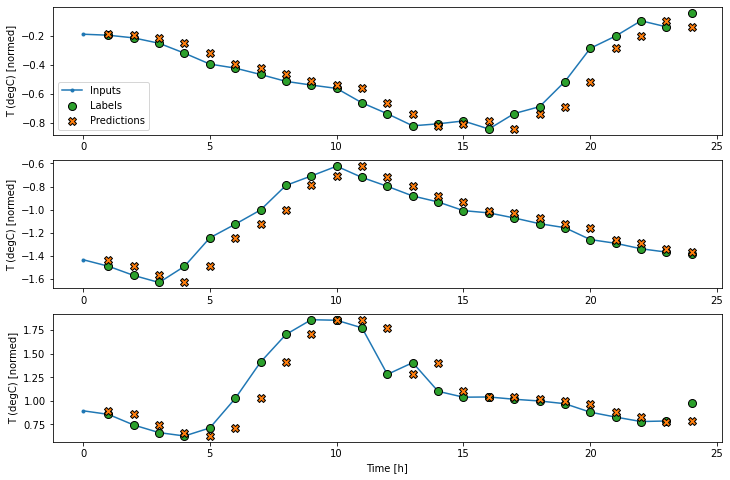

In [38]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)


Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [41]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 8:04 - loss: 0.5087 - mean_absolute_error: 0.6240

  22/1534 [..............................] - ETA: 3s - loss: 0.4000 - mean_absolute_error: 0.5207  

  42/1534 [..............................] - ETA: 3s - loss: 0.3778 - mean_absolute_error: 0.5074

  63/1534 [>.............................] - ETA: 3s - loss: 0.3559 - mean_absolute_error: 0.4952

  84/1534 [>.............................] - ETA: 3s - loss: 0.3289 - mean_absolute_error: 0.4771

 103/1534 [=>............................] - ETA: 3s - loss: 0.3118 - mean_absolute_error: 0.4655

 122/1534 [=>............................] - ETA: 3s - loss: 0.2947 - mean_absolute_error: 0.4520

 143/1534 [=>............................] - ETA: 3s - loss: 0.2778 - mean_absolute_error: 0.4381

 164/1534 [==>...........................] - ETA: 3s - loss: 0.2629 - mean_absolute_error: 0.4253

 184/1534 [==>...........................] - ETA: 3s - loss: 0.2505 - mean_absolute_error: 0.4140

 205/1534 [===>..........................] - ETA: 3s - loss: 0.2394 - mean_absolute_error: 0.4041

 226/1534 [===>..........................] - ETA: 3s - loss: 0.2278 - mean_absolute_error: 0.3935

 246/1534 [===>..........................] - ETA: 3s - loss: 0.2181 - mean_absolute_error: 0.3837

 266/1534 [====>.........................] - ETA: 3s - loss: 0.2093 - mean_absolute_error: 0.3747

 285/1534 [====>.........................] - ETA: 3s - loss: 0.2015 - mean_absolute_error: 0.3667

 305/1534 [====>.........................] - ETA: 3s - loss: 0.1932 - mean_absolute_error: 0.3574

 325/1534 [=====>........................] - ETA: 3s - loss: 0.1858 - mean_absolute_error: 0.3488

 344/1534 [=====>........................] - ETA: 3s - loss: 0.1794 - mean_absolute_error: 0.3413

 365/1534 [======>.......................] - ETA: 2s - loss: 0.1727 - mean_absolute_error: 0.3335

 385/1534 [======>.......................] - ETA: 2s - loss: 0.1668 - mean_absolute_error: 0.3261

 406/1534 [======>.......................] - ETA: 2s - loss: 0.1607 - mean_absolute_error: 0.3184

 426/1534 [=======>......................] - ETA: 2s - loss: 0.1554 - mean_absolute_error: 0.3117

 446/1534 [=======>......................] - ETA: 2s - loss: 0.1505 - mean_absolute_error: 0.3056

 465/1534 [========>.....................] - ETA: 2s - loss: 0.1461 - mean_absolute_error: 0.2998

 485/1534 [========>.....................] - ETA: 2s - loss: 0.1418 - mean_absolute_error: 0.2940

 505/1534 [========>.....................] - ETA: 2s - loss: 0.1377 - mean_absolute_error: 0.2883

 526/1534 [=========>....................] - ETA: 2s - loss: 0.1335 - mean_absolute_error: 0.2825

 547/1534 [=========>....................] - ETA: 2s - loss: 0.1296 - mean_absolute_error: 0.2772

 567/1534 [==========>...................] - ETA: 2s - loss: 0.1263 - mean_absolute_error: 0.2724

 588/1534 [==========>...................] - ETA: 2s - loss: 0.1228 - mean_absolute_error: 0.2675

 609/1534 [==========>...................] - ETA: 2s - loss: 0.1197 - mean_absolute_error: 0.2631

 630/1534 [===========>..................] - ETA: 2s - loss: 0.1167 - mean_absolute_error: 0.2588

 650/1534 [===========>..................] - ETA: 2s - loss: 0.1140 - mean_absolute_error: 0.2550

 671/1534 [============>.................] - ETA: 2s - loss: 0.1114 - mean_absolute_error: 0.2511

 691/1534 [============>.................] - ETA: 2s - loss: 0.1088 - mean_absolute_error: 0.2473

 711/1534 [============>.................] - ETA: 2s - loss: 0.1063 - mean_absolute_error: 0.2435

 731/1534 [=============>................] - ETA: 2s - loss: 0.1041 - mean_absolute_error: 0.2402

 752/1534 [=============>................] - ETA: 1s - loss: 0.1019 - mean_absolute_error: 0.2368

 773/1534 [==============>...............] - ETA: 1s - loss: 0.0997 - mean_absolute_error: 0.2334

 794/1534 [==============>...............] - ETA: 1s - loss: 0.0977 - mean_absolute_error: 0.2303

 815/1534 [==============>...............] - ETA: 1s - loss: 0.0957 - mean_absolute_error: 0.2272

 836/1534 [===============>..............] - ETA: 1s - loss: 0.0938 - mean_absolute_error: 0.2243

 856/1534 [===============>..............] - ETA: 1s - loss: 0.0921 - mean_absolute_error: 0.2215

 877/1534 [================>.............] - ETA: 1s - loss: 0.0904 - mean_absolute_error: 0.2188

 897/1534 [================>.............] - ETA: 1s - loss: 0.0888 - mean_absolute_error: 0.2163

 917/1534 [================>.............] - ETA: 1s - loss: 0.0873 - mean_absolute_error: 0.2140

 938/1534 [=================>............] - ETA: 1s - loss: 0.0858 - mean_absolute_error: 0.2115

 959/1534 [=================>............] - ETA: 1s - loss: 0.0844 - mean_absolute_error: 0.2091

 980/1534 [==================>...........] - ETA: 1s - loss: 0.0830 - mean_absolute_error: 0.2069

1001/1534 [==================>...........] - ETA: 1s - loss: 0.0816 - mean_absolute_error: 0.2047

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0803 - mean_absolute_error: 0.2025

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0790 - mean_absolute_error: 0.2005

1064/1534 [===================>..........] - ETA: 1s - loss: 0.0778 - mean_absolute_error: 0.1986

1085/1534 [====================>.........] - ETA: 1s - loss: 0.0767 - mean_absolute_error: 0.1967

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0756 - mean_absolute_error: 0.1948

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0745 - mean_absolute_error: 0.1929

1148/1534 [=====================>........] - ETA: 0s - loss: 0.0735 - mean_absolute_error: 0.1912

1170/1534 [=====================>........] - ETA: 0s - loss: 0.0724 - mean_absolute_error: 0.1894

1191/1534 [======================>.......] - ETA: 0s - loss: 0.0714 - mean_absolute_error: 0.1876

1212/1534 [======================>.......] - ETA: 0s - loss: 0.0704 - mean_absolute_error: 0.1861

1234/1534 [=======================>......] - ETA: 0s - loss: 0.0694 - mean_absolute_error: 0.1845

1255/1534 [=======================>......] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1829

1276/1534 [=======================>......] - ETA: 0s - loss: 0.0676 - mean_absolute_error: 0.1815

1298/1534 [========================>.....] - ETA: 0s - loss: 0.0667 - mean_absolute_error: 0.1800

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0659 - mean_absolute_error: 0.1786

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0652 - mean_absolute_error: 0.1773

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0644 - mean_absolute_error: 0.1759

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0636 - mean_absolute_error: 0.1745

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0628 - mean_absolute_error: 0.1732

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1719

1447/1534 [===========================>..] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1708

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0607 - mean_absolute_error: 0.1695

1488/1534 [============================>.] - ETA: 0s - loss: 0.0601 - mean_absolute_error: 0.1684

1509/1534 [============================>.] - ETA: 0s - loss: 0.0594 - mean_absolute_error: 0.1672

1531/1534 [============================>.] - ETA: 0s - loss: 0.0587 - mean_absolute_error: 0.1660

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0586 - mean_absolute_error: 0.1659 - val_loss: 0.0135 - val_mean_absolute_error: 0.0858


Epoch 2/20


   1/1534 [..............................] - ETA: 33s - loss: 0.0111 - mean_absolute_error: 0.0831

  22/1534 [..............................] - ETA: 3s - loss: 0.0128 - mean_absolute_error: 0.0844 

  44/1534 [..............................] - ETA: 3s - loss: 0.0135 - mean_absolute_error: 0.0863

  65/1534 [>.............................] - ETA: 3s - loss: 0.0128 - mean_absolute_error: 0.0853

  85/1534 [>.............................] - ETA: 3s - loss: 0.0127 - mean_absolute_error: 0.0846

 106/1534 [=>............................] - ETA: 3s - loss: 0.0131 - mean_absolute_error: 0.0850

 126/1534 [=>............................] - ETA: 3s - loss: 0.0132 - mean_absolute_error: 0.0850

 146/1534 [=>............................] - ETA: 3s - loss: 0.0130 - mean_absolute_error: 0.0844

 166/1534 [==>...........................] - ETA: 3s - loss: 0.0130 - mean_absolute_error: 0.0843

 187/1534 [==>...........................] - ETA: 3s - loss: 0.0129 - mean_absolute_error: 0.0845

 208/1534 [===>..........................] - ETA: 3s - loss: 0.0131 - mean_absolute_error: 0.0849

 229/1534 [===>..........................] - ETA: 3s - loss: 0.0130 - mean_absolute_error: 0.0847

 250/1534 [===>..........................] - ETA: 3s - loss: 0.0128 - mean_absolute_error: 0.0842

 271/1534 [====>.........................] - ETA: 3s - loss: 0.0127 - mean_absolute_error: 0.0839

 292/1534 [====>.........................] - ETA: 3s - loss: 0.0128 - mean_absolute_error: 0.0839

 312/1534 [=====>........................] - ETA: 3s - loss: 0.0127 - mean_absolute_error: 0.0837

 332/1534 [=====>........................] - ETA: 2s - loss: 0.0126 - mean_absolute_error: 0.0835

 352/1534 [=====>........................] - ETA: 2s - loss: 0.0126 - mean_absolute_error: 0.0836

 370/1534 [======>.......................] - ETA: 2s - loss: 0.0126 - mean_absolute_error: 0.0833

 388/1534 [======>.......................] - ETA: 2s - loss: 0.0126 - mean_absolute_error: 0.0834

 407/1534 [======>.......................] - ETA: 2s - loss: 0.0125 - mean_absolute_error: 0.0830

 427/1534 [=======>......................] - ETA: 2s - loss: 0.0124 - mean_absolute_error: 0.0826

 448/1534 [=======>......................] - ETA: 2s - loss: 0.0123 - mean_absolute_error: 0.0825

 469/1534 [========>.....................] - ETA: 2s - loss: 0.0123 - mean_absolute_error: 0.0824

 490/1534 [========>.....................] - ETA: 2s - loss: 0.0124 - mean_absolute_error: 0.0826

 511/1534 [========>.....................] - ETA: 2s - loss: 0.0123 - mean_absolute_error: 0.0824

 532/1534 [=========>....................] - ETA: 2s - loss: 0.0122 - mean_absolute_error: 0.0821

 553/1534 [=========>....................] - ETA: 2s - loss: 0.0121 - mean_absolute_error: 0.0819

 574/1534 [==========>...................] - ETA: 2s - loss: 0.0121 - mean_absolute_error: 0.0818

 595/1534 [==========>...................] - ETA: 2s - loss: 0.0120 - mean_absolute_error: 0.0815

 614/1534 [===========>..................] - ETA: 2s - loss: 0.0121 - mean_absolute_error: 0.0815

 633/1534 [===========>..................] - ETA: 2s - loss: 0.0120 - mean_absolute_error: 0.0815

 654/1534 [===========>..................] - ETA: 2s - loss: 0.0120 - mean_absolute_error: 0.0814

 675/1534 [============>.................] - ETA: 2s - loss: 0.0119 - mean_absolute_error: 0.0811

 696/1534 [============>.................] - ETA: 2s - loss: 0.0119 - mean_absolute_error: 0.0811

 716/1534 [=============>................] - ETA: 2s - loss: 0.0118 - mean_absolute_error: 0.0810

 736/1534 [=============>................] - ETA: 2s - loss: 0.0118 - mean_absolute_error: 0.0808

 757/1534 [=============>................] - ETA: 1s - loss: 0.0117 - mean_absolute_error: 0.0806

 777/1534 [==============>...............] - ETA: 1s - loss: 0.0117 - mean_absolute_error: 0.0805

 795/1534 [==============>...............] - ETA: 1s - loss: 0.0117 - mean_absolute_error: 0.0805

 815/1534 [==============>...............] - ETA: 1s - loss: 0.0117 - mean_absolute_error: 0.0804

 835/1534 [===============>..............] - ETA: 1s - loss: 0.0117 - mean_absolute_error: 0.0804

 855/1534 [===============>..............] - ETA: 1s - loss: 0.0116 - mean_absolute_error: 0.0802

 874/1534 [================>.............] - ETA: 1s - loss: 0.0116 - mean_absolute_error: 0.0802

 894/1534 [================>.............] - ETA: 1s - loss: 0.0116 - mean_absolute_error: 0.0800

 913/1534 [================>.............] - ETA: 1s - loss: 0.0115 - mean_absolute_error: 0.0799

 933/1534 [=================>............] - ETA: 1s - loss: 0.0115 - mean_absolute_error: 0.0798

 953/1534 [=================>............] - ETA: 1s - loss: 0.0115 - mean_absolute_error: 0.0797

 973/1534 [==================>...........] - ETA: 1s - loss: 0.0115 - mean_absolute_error: 0.0797

 993/1534 [==================>...........] - ETA: 1s - loss: 0.0114 - mean_absolute_error: 0.0795

1013/1534 [==================>...........] - ETA: 1s - loss: 0.0114 - mean_absolute_error: 0.0794

1033/1534 [===================>..........] - ETA: 1s - loss: 0.0114 - mean_absolute_error: 0.0793

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.0792

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.0790

1094/1534 [====================>.........] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.0790

1113/1534 [====================>.........] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.0789

1133/1534 [=====================>........] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.0789

1153/1534 [=====================>........] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.0788

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.0787

1193/1534 [======================>.......] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.0786

1214/1534 [======================>.......] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0785

1235/1534 [=======================>......] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0785

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0784

1276/1534 [=======================>......] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0783

1297/1534 [========================>.....] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0782

1317/1534 [========================>.....] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0782

1337/1534 [=========================>....] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0780

1357/1534 [=========================>....] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0779

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0778

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0777

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0776

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0776

1462/1534 [===========================>..] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0775

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0774

1502/1534 [============================>.] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0773

1522/1534 [============================>.] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0772

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0109 - mean_absolute_error: 0.0772 - val_loss: 0.0093 - val_mean_absolute_error: 0.0711


Epoch 3/20


   1/1534 [..............................] - ETA: 32s - loss: 0.0143 - mean_absolute_error: 0.0806

  21/1534 [..............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0702 

  41/1534 [..............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0709

  61/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0717

  81/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0713

 100/1534 [>.............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0716

 119/1534 [=>............................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0720

 138/1534 [=>............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0715

 158/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0712

 177/1534 [==>...........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0716

 196/1534 [==>...........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0714

 215/1534 [===>..........................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0721

 235/1534 [===>..........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0719

 254/1534 [===>..........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0716

 274/1534 [====>.........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0713

 294/1534 [====>.........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0715

 314/1534 [=====>........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0713

 333/1534 [=====>........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0712

 352/1534 [=====>........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0713

 371/1534 [======>.......................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0714

 389/1534 [======>.......................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0716

 408/1534 [======>.......................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0714

 427/1534 [=======>......................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0712

 446/1534 [=======>......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0712

 466/1534 [========>.....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0714

 485/1534 [========>.....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0715

 504/1534 [========>.....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0715

 525/1534 [=========>....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0714

 546/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0712

 567/1534 [==========>...................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0712

 588/1534 [==========>...................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0711

 609/1534 [==========>...................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 630/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 651/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 671/1534 [============>.................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 691/1534 [============>.................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 711/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 732/1534 [=============>................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 751/1534 [=============>................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 771/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 792/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 812/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 832/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 851/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 870/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 890/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 910/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 931/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 951/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 971/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 991/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1011/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1030/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1050/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0706

1070/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0706

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1112/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1133/1534 [=====================>........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1152/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1171/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1191/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1211/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1272/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1334/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1374/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1414/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1474/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704

1494/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704

1514/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0704 - val_loss: 0.0088 - val_mean_absolute_error: 0.0690


Epoch 4/20


   1/1534 [..............................] - ETA: 36s - loss: 0.0132 - mean_absolute_error: 0.0789

  20/1534 [..............................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0655 

  40/1534 [..............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0683

  61/1534 [>.............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0692

  82/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0699

 102/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0699

 123/1534 [=>............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0703

 143/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0695

 163/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0693

 183/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0698

 203/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0698

 223/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0699

 244/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0699

 264/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0697

 284/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 304/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0698

 324/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 344/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 365/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 386/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0699

 406/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 427/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 448/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 468/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0699

 489/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 509/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 528/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 548/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 568/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 589/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 609/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 630/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 670/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 690/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 710/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 730/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 750/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 770/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 790/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 811/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 832/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 853/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 873/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 893/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 913/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 933/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 953/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 974/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 994/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1035/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1097/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1116/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1155/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1175/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1196/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1217/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1236/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1278/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1298/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1359/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1379/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1418/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1439/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1459/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1480/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1501/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1522/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0089 - val_mean_absolute_error: 0.0692


Epoch 5/20


   1/1534 [..............................] - ETA: 33s - loss: 0.0115 - mean_absolute_error: 0.0778

  21/1534 [..............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0692 

  41/1534 [..............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0678

  61/1534 [>.............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0690

  82/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0692

 101/1534 [>.............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0695

 120/1534 [=>............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0700

 139/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0693

 157/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0691

 177/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0694

 196/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0695

 216/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0698

 235/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0699

 254/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0696

 272/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0694

 291/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 310/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 329/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0693

 348/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 367/1534 [======>.......................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0697

 386/1534 [======>.......................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0699

 406/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 426/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0697

 446/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 466/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 484/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 503/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 522/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 541/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 560/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 579/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 599/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 618/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 637/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 657/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 678/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 698/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 718/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 738/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 757/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 775/1534 [==============>...............] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 794/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 813/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 832/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 852/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 872/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 891/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 911/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 931/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 951/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 970/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 990/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1009/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1067/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1126/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1146/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1166/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1187/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1208/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1229/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1249/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1289/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1310/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1369/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1389/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1430/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1450/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1470/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1490/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1510/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1531/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0088 - val_mean_absolute_error: 0.0685


Epoch 6/20


   1/1534 [..............................] - ETA: 35s - loss: 0.0138 - mean_absolute_error: 0.0848

  21/1534 [..............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0686 

  42/1534 [..............................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0703

  63/1534 [>.............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0692

  84/1534 [>.............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0692

 105/1534 [=>............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0697

 125/1534 [=>............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0698

 145/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0696

 165/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0692

 185/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0697

 205/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0699

 224/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0701

 245/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0699

 264/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0696

 285/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0696

 304/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0697

 324/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 345/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 366/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0697

 386/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 406/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 427/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 448/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 469/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 489/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 507/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 527/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 548/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 568/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 589/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0699

 610/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 630/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 651/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0699

 671/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 692/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 712/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 732/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 752/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 772/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 792/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 813/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 833/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 853/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 873/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 894/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 914/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 934/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 954/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 996/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1017/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1078/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1120/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1140/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1160/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1181/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1202/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1223/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1264/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1285/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1326/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1448/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1488/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1509/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1531/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0087 - val_mean_absolute_error: 0.0687


Epoch 7/20


   1/1534 [..............................] - ETA: 33s - loss: 0.0048 - mean_absolute_error: 0.0507

  21/1534 [..............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0674 

  42/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0679

  63/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0684

  83/1534 [>.............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0691

 104/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0697

 123/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0696

 143/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0691

 162/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0692

 183/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0694

 204/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0695

 225/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0695

 246/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0696

 267/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0695

 288/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0695

 309/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 329/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0694

 348/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 369/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0697

 389/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 409/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 429/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 450/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 470/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 491/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0699

 511/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 532/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 553/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 574/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 593/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0697

 611/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 631/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 651/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 672/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 692/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 713/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 734/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 754/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 774/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 794/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 815/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 836/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 857/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 878/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 899/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 919/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 938/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 957/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1074/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1094/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1113/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1134/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1154/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1174/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1195/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1215/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1234/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1254/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1274/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1373/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1392/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1411/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1430/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1449/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1469/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1487/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1505/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1524/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0087 - val_mean_absolute_error: 0.0680


Epoch 8/20


   1/1534 [..............................] - ETA: 35s - loss: 0.0057 - mean_absolute_error: 0.0610

  20/1534 [..............................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0665 

  41/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0678

  61/1534 [>.............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0685

  81/1534 [>.............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0685

 101/1534 [>.............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0692

 120/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0691

 139/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0691

 159/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0687

 179/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0695

 198/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0692

 218/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0696

 238/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0696

 258/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0694

 278/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0694

 298/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0696

 318/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0694

 338/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0694

 358/1534 [======>.......................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 378/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0696

 398/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 419/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 439/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 458/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 478/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 495/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 516/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 536/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 555/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 574/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 594/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 615/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 636/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 656/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 676/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 695/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 716/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 735/1534 [=============>................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 752/1534 [=============>................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 770/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 788/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 807/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 826/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 844/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 863/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 882/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 901/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 920/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 939/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 958/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1013/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1032/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1052/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1089/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

1109/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1129/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1149/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1168/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1188/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1207/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1226/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1308/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0695

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0695

1478/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0695

1498/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0695

1518/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0695 - val_loss: 0.0087 - val_mean_absolute_error: 0.0683


Epoch 9/20


   1/1534 [..............................] - ETA: 37s - loss: 0.0047 - mean_absolute_error: 0.0540

  19/1534 [..............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0654 

  38/1534 [..............................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0673

  57/1534 [>.............................] - ETA: 4s - loss: 0.0091 - mean_absolute_error: 0.0682

  76/1534 [>.............................] - ETA: 4s - loss: 0.0089 - mean_absolute_error: 0.0684

  95/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0695

 114/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0694

 133/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0689

 152/1534 [=>............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0691

 171/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0691

 191/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0690

 211/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0694

 231/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0696

 252/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0696

 272/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0692

 293/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 314/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 334/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 354/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 374/1534 [======>.......................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0697

 394/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 414/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0696

 435/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 455/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 476/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 496/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 516/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 535/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 556/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 577/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 597/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 617/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 637/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 658/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 678/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 698/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 719/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 739/1534 [=============>................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 759/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 780/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 800/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 820/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 840/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 860/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 881/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 901/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 921/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 941/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 961/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 980/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 999/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1018/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1035/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1074/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

1113/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1133/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1153/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1193/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1212/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1233/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1294/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1334/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1355/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1376/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1397/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1417/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1437/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1498/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1518/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0696 - val_loss: 0.0087 - val_mean_absolute_error: 0.0684


  1/439 [..............................] - ETA: 26s - loss: 0.0167 - mean_absolute_error: 0.0937

 23/439 [>.............................] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0677 

 47/439 [==>...........................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0672

 70/439 [===>..........................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0673

 93/439 [=====>........................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0678

117/439 [======>.......................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0676

140/439 [========>.....................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0677

164/439 [==========>...................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0672

188/439 [===========>..................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0677

212/439 [=============>................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0679

236/439 [===============>..............] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0678

261/439 [================>.............] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0679

285/439 [==================>...........] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0680

309/439 [====================>.........] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0680

333/439 [=====================>........] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0683

357/439 [=======================>......] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0682

379/439 [========================>.....] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0682

403/439 [==========================>...] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0683

427/439 [============================>.] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0684

439/439 [==============================] - 1s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0684


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

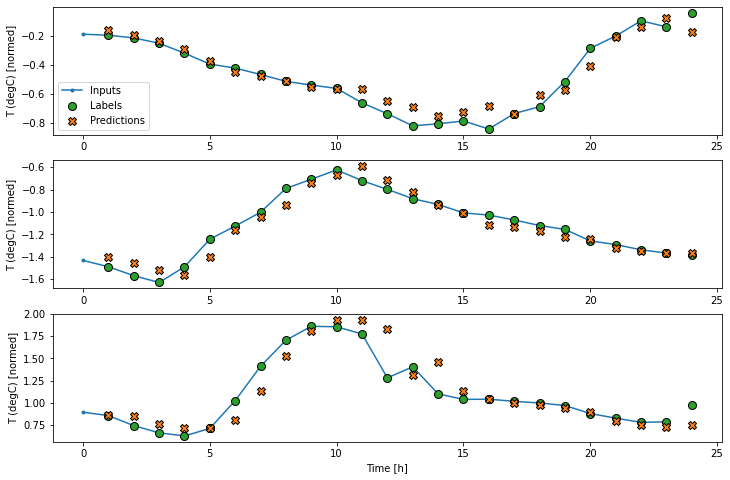

In [44]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights and visualize the weight assigned to each input:

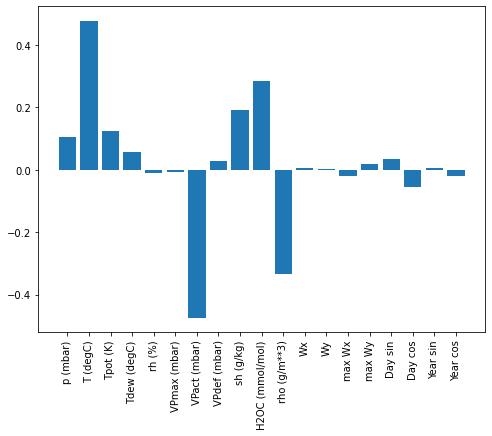

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 11:54 - loss: 0.7099 - mean_absolute_error: 0.6472

  17/1534 [..............................] - ETA: 4s - loss: 0.2515 - mean_absolute_error: 0.3582   

  33/1534 [..............................] - ETA: 4s - loss: 0.1571 - mean_absolute_error: 0.2756

  49/1534 [..............................] - ETA: 4s - loss: 0.1150 - mean_absolute_error: 0.2274

  65/1534 [>.............................] - ETA: 4s - loss: 0.0923 - mean_absolute_error: 0.1992

  80/1534 [>.............................] - ETA: 4s - loss: 0.0786 - mean_absolute_error: 0.1816

  95/1534 [>.............................] - ETA: 4s - loss: 0.0687 - mean_absolute_error: 0.1685

 111/1534 [=>............................] - ETA: 4s - loss: 0.0609 - mean_absolute_error: 0.1575

 127/1534 [=>............................] - ETA: 4s - loss: 0.0551 - mean_absolute_error: 0.1494

 143/1534 [=>............................] - ETA: 4s - loss: 0.0502 - mean_absolute_error: 0.1420

 159/1534 [==>...........................] - ETA: 4s - loss: 0.0465 - mean_absolute_error: 0.1362

 175/1534 [==>...........................] - ETA: 4s - loss: 0.0435 - mean_absolute_error: 0.1319

 191/1534 [==>...........................] - ETA: 4s - loss: 0.0409 - mean_absolute_error: 0.1278

 207/1534 [===>..........................] - ETA: 4s - loss: 0.0386 - mean_absolute_error: 0.1245

 223/1534 [===>..........................] - ETA: 4s - loss: 0.0367 - mean_absolute_error: 0.1214

 238/1534 [===>..........................] - ETA: 4s - loss: 0.0353 - mean_absolute_error: 0.1192

 254/1534 [===>..........................] - ETA: 4s - loss: 0.0339 - mean_absolute_error: 0.1168

 270/1534 [====>.........................] - ETA: 4s - loss: 0.0326 - mean_absolute_error: 0.1148

 285/1534 [====>.........................] - ETA: 4s - loss: 0.0314 - mean_absolute_error: 0.1128

 300/1534 [====>.........................] - ETA: 4s - loss: 0.0303 - mean_absolute_error: 0.1108

 316/1534 [=====>........................] - ETA: 4s - loss: 0.0293 - mean_absolute_error: 0.1094

 332/1534 [=====>........................] - ETA: 3s - loss: 0.0284 - mean_absolute_error: 0.1077

 348/1534 [=====>........................] - ETA: 3s - loss: 0.0277 - mean_absolute_error: 0.1066

 363/1534 [======>.......................] - ETA: 3s - loss: 0.0269 - mean_absolute_error: 0.1054

 378/1534 [======>.......................] - ETA: 3s - loss: 0.0262 - mean_absolute_error: 0.1040

 394/1534 [======>.......................] - ETA: 3s - loss: 0.0256 - mean_absolute_error: 0.1027

 409/1534 [======>.......................] - ETA: 3s - loss: 0.0250 - mean_absolute_error: 0.1018

 425/1534 [=======>......................] - ETA: 3s - loss: 0.0244 - mean_absolute_error: 0.1007

 441/1534 [=======>......................] - ETA: 3s - loss: 0.0240 - mean_absolute_error: 0.1000

 456/1534 [=======>......................] - ETA: 3s - loss: 0.0236 - mean_absolute_error: 0.0991

 472/1534 [========>.....................] - ETA: 3s - loss: 0.0231 - mean_absolute_error: 0.0983

 487/1534 [========>.....................] - ETA: 3s - loss: 0.0227 - mean_absolute_error: 0.0975

 502/1534 [========>.....................] - ETA: 3s - loss: 0.0223 - mean_absolute_error: 0.0967

 518/1534 [=========>....................] - ETA: 3s - loss: 0.0219 - mean_absolute_error: 0.0959

 534/1534 [=========>....................] - ETA: 3s - loss: 0.0215 - mean_absolute_error: 0.0952

 550/1534 [=========>....................] - ETA: 3s - loss: 0.0212 - mean_absolute_error: 0.0946

 566/1534 [==========>...................] - ETA: 3s - loss: 0.0209 - mean_absolute_error: 0.0940

 582/1534 [==========>...................] - ETA: 3s - loss: 0.0206 - mean_absolute_error: 0.0934

 598/1534 [==========>...................] - ETA: 3s - loss: 0.0203 - mean_absolute_error: 0.0929

 613/1534 [==========>...................] - ETA: 3s - loss: 0.0200 - mean_absolute_error: 0.0925

 628/1534 [===========>..................] - ETA: 2s - loss: 0.0198 - mean_absolute_error: 0.0920

 644/1534 [===========>..................] - ETA: 2s - loss: 0.0195 - mean_absolute_error: 0.0916

 659/1534 [===========>..................] - ETA: 2s - loss: 0.0193 - mean_absolute_error: 0.0910

 674/1534 [============>.................] - ETA: 2s - loss: 0.0190 - mean_absolute_error: 0.0906

 688/1534 [============>.................] - ETA: 2s - loss: 0.0188 - mean_absolute_error: 0.0901

 703/1534 [============>.................] - ETA: 2s - loss: 0.0186 - mean_absolute_error: 0.0896

 718/1534 [=============>................] - ETA: 2s - loss: 0.0184 - mean_absolute_error: 0.0892

 733/1534 [=============>................] - ETA: 2s - loss: 0.0182 - mean_absolute_error: 0.0887

 747/1534 [=============>................] - ETA: 2s - loss: 0.0181 - mean_absolute_error: 0.0884

 761/1534 [=============>................] - ETA: 2s - loss: 0.0180 - mean_absolute_error: 0.0883

 776/1534 [==============>...............] - ETA: 2s - loss: 0.0178 - mean_absolute_error: 0.0878

 791/1534 [==============>...............] - ETA: 2s - loss: 0.0176 - mean_absolute_error: 0.0874

 806/1534 [==============>...............] - ETA: 2s - loss: 0.0174 - mean_absolute_error: 0.0870

 821/1534 [===============>..............] - ETA: 2s - loss: 0.0172 - mean_absolute_error: 0.0867

 836/1534 [===============>..............] - ETA: 2s - loss: 0.0171 - mean_absolute_error: 0.0863

 851/1534 [===============>..............] - ETA: 2s - loss: 0.0169 - mean_absolute_error: 0.0859

 866/1534 [===============>..............] - ETA: 2s - loss: 0.0168 - mean_absolute_error: 0.0857

 881/1534 [================>.............] - ETA: 2s - loss: 0.0166 - mean_absolute_error: 0.0853

 896/1534 [================>.............] - ETA: 2s - loss: 0.0165 - mean_absolute_error: 0.0851

 910/1534 [================>.............] - ETA: 2s - loss: 0.0164 - mean_absolute_error: 0.0848

 924/1534 [=================>............] - ETA: 2s - loss: 0.0163 - mean_absolute_error: 0.0846

 938/1534 [=================>............] - ETA: 2s - loss: 0.0162 - mean_absolute_error: 0.0844

 952/1534 [=================>............] - ETA: 1s - loss: 0.0161 - mean_absolute_error: 0.0842

 966/1534 [=================>............] - ETA: 1s - loss: 0.0160 - mean_absolute_error: 0.0840

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0159 - mean_absolute_error: 0.0837

 996/1534 [==================>...........] - ETA: 1s - loss: 0.0158 - mean_absolute_error: 0.0835

1011/1534 [==================>...........] - ETA: 1s - loss: 0.0157 - mean_absolute_error: 0.0834

1025/1534 [===================>..........] - ETA: 1s - loss: 0.0156 - mean_absolute_error: 0.0833

1039/1534 [===================>..........] - ETA: 1s - loss: 0.0155 - mean_absolute_error: 0.0831

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0154 - mean_absolute_error: 0.0828

1069/1534 [===================>..........] - ETA: 1s - loss: 0.0153 - mean_absolute_error: 0.0826

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0152 - mean_absolute_error: 0.0824

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0152 - mean_absolute_error: 0.0823

1113/1534 [====================>.........] - ETA: 1s - loss: 0.0151 - mean_absolute_error: 0.0821

1128/1534 [=====================>........] - ETA: 1s - loss: 0.0150 - mean_absolute_error: 0.0818

1142/1534 [=====================>........] - ETA: 1s - loss: 0.0149 - mean_absolute_error: 0.0816

1157/1534 [=====================>........] - ETA: 1s - loss: 0.0148 - mean_absolute_error: 0.0814

1172/1534 [=====================>........] - ETA: 1s - loss: 0.0147 - mean_absolute_error: 0.0813

1187/1534 [======================>.......] - ETA: 1s - loss: 0.0146 - mean_absolute_error: 0.0811

1202/1534 [======================>.......] - ETA: 1s - loss: 0.0145 - mean_absolute_error: 0.0809

1217/1534 [======================>.......] - ETA: 1s - loss: 0.0145 - mean_absolute_error: 0.0807

1232/1534 [=======================>......] - ETA: 1s - loss: 0.0144 - mean_absolute_error: 0.0806

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0805

1262/1534 [=======================>......] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0803

1277/1534 [=======================>......] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0802

1292/1534 [========================>.....] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0801

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0799

1321/1534 [========================>.....] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0798

1336/1534 [=========================>....] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0795

1351/1534 [=========================>....] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0794

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0793

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0793

1396/1534 [==========================>...] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0791

1411/1534 [==========================>...] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0790

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0788

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0787

1456/1534 [===========================>..] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0786

1470/1534 [===========================>..] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0784

1485/1534 [============================>.] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0783

1499/1534 [============================>.] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0782

1514/1534 [============================>.] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0781

1529/1534 [============================>.] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0779

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0132 - mean_absolute_error: 0.0779 - val_loss: 0.0081 - val_mean_absolute_error: 0.0666


Epoch 2/20


   1/1534 [..............................] - ETA: 37s - loss: 0.0099 - mean_absolute_error: 0.0758

  15/1534 [..............................] - ETA: 5s - loss: 0.0086 - mean_absolute_error: 0.0697 

  29/1534 [..............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0661

  44/1534 [..............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0653

  58/1534 [>.............................] - ETA: 5s - loss: 0.0080 - mean_absolute_error: 0.0657

  72/1534 [>.............................] - ETA: 5s - loss: 0.0080 - mean_absolute_error: 0.0662

  86/1534 [>.............................] - ETA: 5s - loss: 0.0079 - mean_absolute_error: 0.0661

 100/1534 [>.............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0652

 114/1534 [=>............................] - ETA: 5s - loss: 0.0079 - mean_absolute_error: 0.0657

 129/1534 [=>............................] - ETA: 5s - loss: 0.0079 - mean_absolute_error: 0.0656

 144/1534 [=>............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0659

 159/1534 [==>...........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0664

 174/1534 [==>...........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0664

 189/1534 [==>...........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0663

 204/1534 [==>...........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0662

 220/1534 [===>..........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0660

 235/1534 [===>..........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0663

 249/1534 [===>..........................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0669

 264/1534 [====>.........................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0672

 279/1534 [====>.........................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0672

 293/1534 [====>.........................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0670

 307/1534 [=====>........................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0671

 321/1534 [=====>........................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0671

 336/1534 [=====>........................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0670

 350/1534 [=====>........................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0669

 364/1534 [======>.......................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0668

 379/1534 [======>.......................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0667

 394/1534 [======>.......................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0668

 409/1534 [======>.......................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0667

 423/1534 [=======>......................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0667

 437/1534 [=======>......................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0666

 452/1534 [=======>......................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0665

 467/1534 [========>.....................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0666

 481/1534 [========>.....................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0665

 495/1534 [========>.....................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0665

 509/1534 [========>.....................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0665

 524/1534 [=========>....................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0664

 539/1534 [=========>....................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0665

 554/1534 [=========>....................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0664

 569/1534 [==========>...................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0664

 583/1534 [==========>...................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0664

 597/1534 [==========>...................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0662

 612/1534 [==========>...................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0661

 626/1534 [===========>..................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0661

 641/1534 [===========>..................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0663

 656/1534 [===========>..................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0662

 671/1534 [============>.................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0661

 686/1534 [============>.................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0661

 701/1534 [============>.................] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0661

 716/1534 [=============>................] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0661

 731/1534 [=============>................] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0661

 746/1534 [=============>................] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0661

 760/1534 [=============>................] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0661

 775/1534 [==============>...............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0660

 790/1534 [==============>...............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0659

 805/1534 [==============>...............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0659

 820/1534 [===============>..............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0659

 834/1534 [===============>..............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0659

 849/1534 [===============>..............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0659

 864/1534 [===============>..............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0658

 879/1534 [================>.............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0658

 893/1534 [================>.............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0658

 908/1534 [================>.............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0658

 923/1534 [=================>............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0658

 938/1534 [=================>............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0658

 953/1534 [=================>............] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0657

 968/1534 [=================>............] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0657

 983/1534 [==================>...........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0658

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0658

1013/1534 [==================>...........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0658

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0658

1045/1534 [===================>..........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0658

1061/1534 [===================>..........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0657

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0657

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0657

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0657

1121/1534 [====================>.........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0656

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0656

1151/1534 [=====================>........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0655

1166/1534 [=====================>........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0655

1181/1534 [======================>.......] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0655

1196/1534 [======================>.......] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0655

1211/1534 [======================>.......] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0654

1226/1534 [======================>.......] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0655

1241/1534 [=======================>......] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0655

1255/1534 [=======================>......] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0655

1270/1534 [=======================>......] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0655

1285/1534 [========================>.....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0655

1300/1534 [========================>.....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1315/1534 [========================>.....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0653

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0653

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0653

1375/1534 [=========================>....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0653

1390/1534 [==========================>...] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0653

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0653

1421/1534 [==========================>...] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1466/1534 [===========================>..] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1481/1534 [===========================>..] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1496/1534 [============================>.] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0654

1511/1534 [============================>.] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0653

1527/1534 [============================>.] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0652

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0081 - mean_absolute_error: 0.0652 - val_loss: 0.0073 - val_mean_absolute_error: 0.0610


Epoch 3/20


   1/1534 [..............................] - ETA: 37s - loss: 0.0047 - mean_absolute_error: 0.0559

  16/1534 [..............................] - ETA: 5s - loss: 0.0076 - mean_absolute_error: 0.0643 

  32/1534 [..............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

  48/1534 [..............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0615

  64/1534 [>.............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0615

  80/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0612

  95/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0609

 110/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0611

 125/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0609

 140/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0613

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0619

 171/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0618

 186/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0617

 200/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0613

 215/1534 [===>..........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0613

 230/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0618

 245/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0622

 260/1534 [====>.........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0625

 275/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0626

 290/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0626

 306/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0625

 322/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0623

 337/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0621

 352/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0623

 367/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0623

 383/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0622

 398/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0622

 413/1534 [=======>......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0625

 428/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0625

 443/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0624

 458/1534 [=======>......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0626

 473/1534 [========>.....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0628

 488/1534 [========>.....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0627

 504/1534 [========>.....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0628

 520/1534 [=========>....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0629

 535/1534 [=========>....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0628

 550/1534 [=========>....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0628

 565/1534 [==========>...................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0629

 580/1534 [==========>...................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0629

 596/1534 [==========>...................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0630

 611/1534 [==========>...................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0631

 626/1534 [===========>..................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0630

 642/1534 [===========>..................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0630

 657/1534 [===========>..................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0629

 673/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0629

 689/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0630

 704/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0629

 720/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 736/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 751/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 766/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 782/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 798/1534 [==============>...............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 814/1534 [==============>...............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 830/1534 [===============>..............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 846/1534 [===============>..............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 861/1534 [===============>..............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 876/1534 [================>.............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0626

 891/1534 [================>.............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 907/1534 [================>.............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 923/1534 [=================>............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 940/1534 [=================>............] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0628

 956/1534 [=================>............] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0628

 973/1534 [==================>...........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

 989/1534 [==================>...........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

1005/1534 [==================>...........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0630

1020/1534 [==================>...........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

1036/1534 [===================>..........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

1051/1534 [===================>..........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

1067/1534 [===================>..........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

1083/1534 [====================>.........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0630

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0630

1115/1534 [====================>.........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0632

1131/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0631

1147/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0630

1163/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0630

1179/1534 [======================>.......] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0630

1194/1534 [======================>.......] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0630

1210/1534 [======================>.......] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0630

1226/1534 [======================>.......] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0631

1240/1534 [=======================>......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0631

1255/1534 [=======================>......] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0631

1270/1534 [=======================>......] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0632

1285/1534 [========================>.....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0631

1300/1534 [========================>.....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0631

1315/1534 [========================>.....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0631

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1375/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1390/1534 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1439/1534 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1469/1534 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1485/1534 [============================>.] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1501/1534 [============================>.] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1517/1534 [============================>.] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0627

1534/1534 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0627

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0076 - mean_absolute_error: 0.0627 - val_loss: 0.0072 - val_mean_absolute_error: 0.0618


Epoch 4/20


   1/1534 [..............................] - ETA: 34s - loss: 0.0074 - mean_absolute_error: 0.0618

  17/1534 [..............................] - ETA: 5s - loss: 0.0068 - mean_absolute_error: 0.0614 

  33/1534 [..............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0618

  49/1534 [..............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0604

  65/1534 [>.............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0612

  80/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0607

  96/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0605

 112/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0610

 126/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0603

 141/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0608

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0606

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0609

 188/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0609

 204/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0607

 220/1534 [===>..........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0610

 236/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0612

 252/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0609

 268/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0609

 284/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0608

 299/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0608

 315/1534 [=====>........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0607

 331/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 346/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 378/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 393/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 408/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 423/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 453/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 468/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0609

 483/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0609

 499/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 515/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 530/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 545/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 560/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0613

 575/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0615

 590/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0616

 605/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0616

 620/1534 [===========>..................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 635/1534 [===========>..................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 665/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 680/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 695/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 710/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 725/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 740/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0614

 755/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 770/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 785/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 800/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 815/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 829/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 844/1534 [===============>..............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 859/1534 [===============>..............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 874/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 890/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0610

 905/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 920/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 935/1534 [=================>............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 950/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

 965/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

 979/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

 994/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

1009/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1039/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1083/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1098/1534 [====================>.........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1113/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1128/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1142/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0610

1155/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0610

1169/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

1184/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0610

1199/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0610

1214/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

1229/1534 [=======================>......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1259/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1274/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1289/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1304/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1377/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1393/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1453/1534 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1469/1534 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1485/1534 [============================>.] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1501/1534 [============================>.] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

1517/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1534/1534 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0609 - val_loss: 0.0068 - val_mean_absolute_error: 0.0582


Epoch 5/20


   1/1534 [..............................] - ETA: 36s - loss: 0.0082 - mean_absolute_error: 0.0647

  16/1534 [..............................] - ETA: 5s - loss: 0.0073 - mean_absolute_error: 0.0641 

  32/1534 [..............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0638

  47/1534 [..............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0649

  62/1534 [>.............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0648

  78/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0635

  93/1534 [>.............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0631

 109/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0628

 125/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0628

 141/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0627

 157/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0624

 173/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0626

 189/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0623

 205/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0620

 220/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0619

 235/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0618

 250/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0618

 266/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0615

 282/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0615

 298/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0611

 314/1534 [=====>........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 330/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 346/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 377/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0604

 392/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0605

 407/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 422/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 454/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 470/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 486/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 502/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 518/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 534/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 549/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 564/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 580/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0609

 596/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 612/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0609

 643/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0610

 659/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0610

 675/1534 [============>.................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0610

 691/1534 [============>.................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0610

 707/1534 [============>.................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0609

 723/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0608

 739/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0607

 754/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0608

 770/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0608

 785/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0608

 801/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0607

 816/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0607

 831/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0607

 846/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0607

 862/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0607

 877/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0608

 893/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0608

 908/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0608

 923/1534 [=================>............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0608

 939/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

 954/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

 969/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1032/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1062/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1078/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

1111/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

1126/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

1141/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1157/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0607

1173/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1189/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1205/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1221/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1285/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1301/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1317/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1397/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1413/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1493/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1509/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1525/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0606 - val_loss: 0.0066 - val_mean_absolute_error: 0.0581


Epoch 6/20


   1/1534 [..............................] - ETA: 34s - loss: 0.0079 - mean_absolute_error: 0.0604

  16/1534 [..............................] - ETA: 5s - loss: 0.0062 - mean_absolute_error: 0.0590 

  32/1534 [..............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0588

  48/1534 [..............................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0578

  64/1534 [>.............................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0570

  79/1534 [>.............................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0571

  94/1534 [>.............................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0577

 110/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0580

 125/1534 [=>............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0576

 141/1534 [=>............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0573

 157/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0579

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0583

 188/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0582

 203/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0583

 218/1534 [===>..........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0586

 233/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0590

 249/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0590

 265/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0592

 280/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0589

 296/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0589

 312/1534 [=====>........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0590

 328/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 343/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 358/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 374/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 390/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0589

 406/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 422/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 454/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 470/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 486/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 502/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 516/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0592

 531/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0592

 547/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0594

 562/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0595

 578/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 593/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 608/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 623/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 639/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 654/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 670/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 686/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 702/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 717/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0594

 733/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 749/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 765/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0595

 781/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 797/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 813/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 829/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 845/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 860/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0591

 875/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0591

 890/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0591

 905/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0591

 921/1534 [=================>............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0591

 937/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

 953/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

 969/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1015/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1030/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1046/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1062/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1078/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1094/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1126/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1142/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1158/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1174/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1190/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1205/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1221/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1285/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1301/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1317/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1393/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1456/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1488/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1503/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1518/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0594 - val_loss: 0.0067 - val_mean_absolute_error: 0.0579


Epoch 7/20


   1/1534 [..............................] - ETA: 35s - loss: 0.0067 - mean_absolute_error: 0.0575

  16/1534 [..............................] - ETA: 5s - loss: 0.0072 - mean_absolute_error: 0.0601 

  32/1534 [..............................] - ETA: 5s - loss: 0.0066 - mean_absolute_error: 0.0582

  48/1534 [..............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0580

  64/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0580

  79/1534 [>.............................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0575

  95/1534 [>.............................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0577

 112/1534 [=>............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0582

 128/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0584

 144/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0587

 159/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0588

 175/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0588

 191/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0587

 207/1534 [===>..........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0584

 223/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0586

 239/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0589

 255/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0594

 271/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 287/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 303/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0589

 319/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 334/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 349/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 364/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 379/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0587

 394/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 410/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 426/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 442/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 458/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0588

 474/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0589

 490/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0587

 506/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0588

 522/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0588

 538/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 554/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 570/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 586/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 602/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 618/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 634/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 665/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 680/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 696/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 711/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 727/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 743/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 759/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 775/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 791/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 807/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 823/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 838/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 854/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 869/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 885/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 901/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0587

 917/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0587

 933/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0587

 949/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0587

 965/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1030/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1046/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1061/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1077/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0591

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1123/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1138/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1154/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1169/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1184/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1199/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0591

1215/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0591

1230/1534 [=======================>......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0591

1245/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1277/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1309/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0591

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0591

1340/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1356/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0591

1371/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1387/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0591

1403/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1450/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1466/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1499/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1515/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1532/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0590 - val_loss: 0.0068 - val_mean_absolute_error: 0.0580


  1/439 [..............................] - ETA: 25s - loss: 0.0075 - mean_absolute_error: 0.0573

 21/439 [>.............................] - ETA: 1s - loss: 0.0086 - mean_absolute_error: 0.0587 

 41/439 [=>............................] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0575

 60/439 [===>..........................] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0590

 79/439 [====>.........................] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0589

 98/439 [=====>........................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0580

117/439 [======>.......................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0574

136/439 [========>.....................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0574

155/439 [=========>....................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0573

175/439 [==========>...................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0573

194/439 [============>.................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0578

213/439 [=============>................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0577

233/439 [==============>...............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0575

252/439 [================>.............] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0572

271/439 [=================>............] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0571

290/439 [==================>...........] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0575

309/439 [====================>.........] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0575

329/439 [=====================>........] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0578

349/439 [======================>.......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0579

368/439 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

387/439 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0581

407/439 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0579

426/439 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0579

439/439 [==============================] - 1s 3ms/step - loss: 0.0068 - mean_absolute_error: 0.0580


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

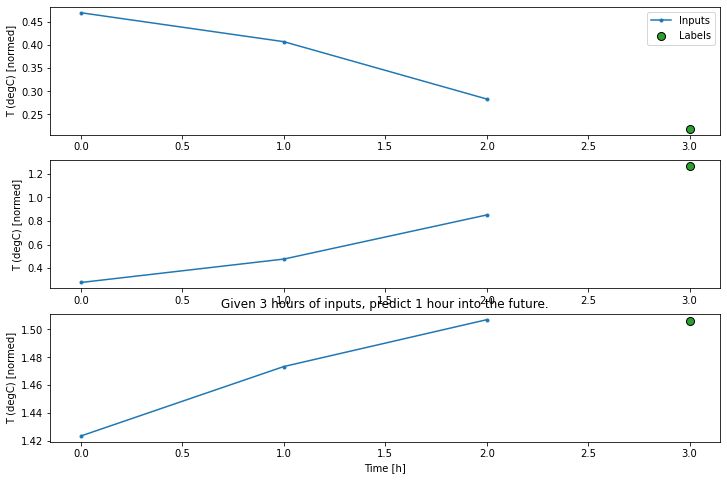

In [48]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 29s - loss: 0.0091 - mean_absolute_error: 0.0662

 26/438 [>.............................] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0609 

 53/438 [==>...........................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

 78/438 [====>.........................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0596

103/438 [======>.......................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0598

129/438 [=======>......................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0596

154/438 [=========>....................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0603

180/438 [===========>..................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

207/438 [=============>................] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0612

233/438 [==============>...............] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0612

259/438 [================>.............] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0614

285/438 [==================>...........] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0613

311/438 [====================>.........] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0612

337/438 [======================>.......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0609

363/438 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0608

390/438 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0608

416/438 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0610

438/438 [==============================] - 1s 2ms/step - loss: 0.0070 - mean_absolute_error: 0.0609


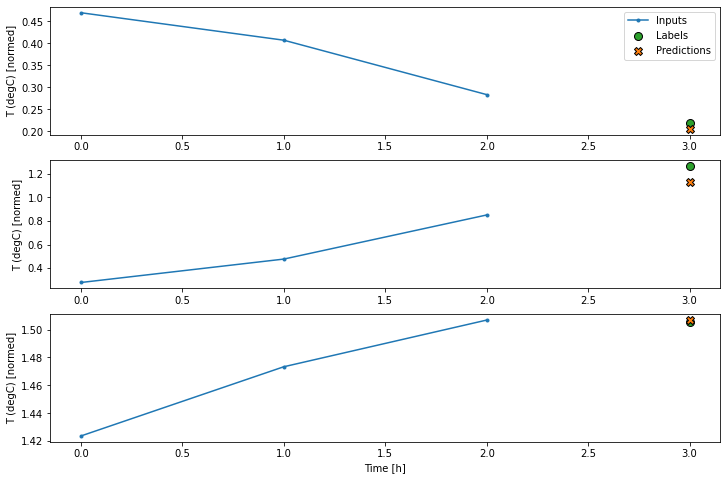

In [52]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to check that the model produces outputs with the expected shape:

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 27s - loss: 0.0132 - mean_absolute_error: 0.0883

 21/438 [>.............................] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0571 

 42/438 [=>............................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0560

 62/438 [===>..........................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0554

 82/438 [====>.........................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0557

102/438 [=====>........................] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0553

122/438 [=======>......................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0559

142/438 [========>.....................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0563

161/438 [==========>...................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0561

180/438 [===========>..................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0563

200/438 [============>.................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0562

219/438 [==============>...............] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0566

239/438 [===============>..............] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0567

259/438 [================>.............] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0567

279/438 [==================>...........] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0569

299/438 [===================>..........] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0569

319/438 [====================>.........] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0566

338/438 [======================>.......] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0565

358/438 [=======================>......] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0566

377/438 [========================>.....] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0567

397/438 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

417/438 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

438/438 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0568

438/438 [==============================] - 1s 3ms/step - loss: 0.0063 - mean_absolute_error: 0.0568


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [59]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

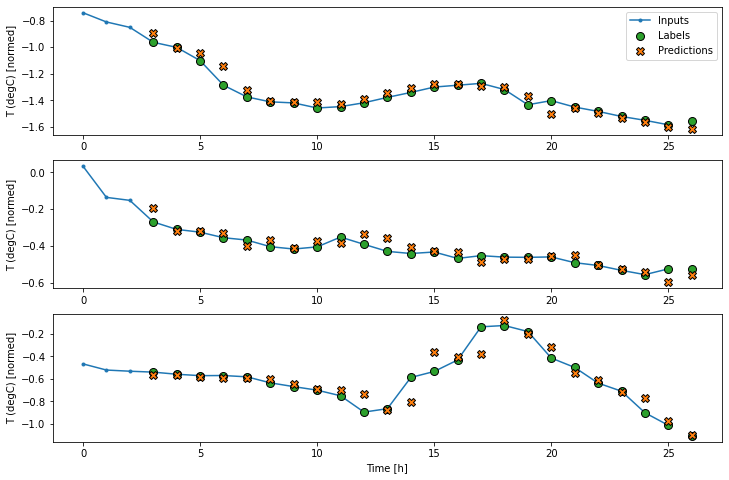

In [60]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 

![An LSTM warming up and making a single prediction](images/lstm_1_window.png)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](images/lstm_many_window.png)

In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


Output shape: (32, 24, 1)


In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 33s - loss: 0.0058 - mean_absolute_error: 0.0520

 18/438 [>.............................] - ETA: 1s - loss: 0.0053 - mean_absolute_error: 0.0501 

 36/438 [=>............................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0509

 54/438 [==>...........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0512

 72/438 [===>..........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0514

 91/438 [=====>........................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0514

110/438 [======>.......................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0514

129/438 [=======>......................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0512

147/438 [=========>....................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0513

164/438 [==========>...................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0512

182/438 [===========>..................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0512

200/438 [============>.................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0510

218/438 [=============>................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0510

236/438 [===============>..............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0510

254/438 [================>.............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

272/438 [=================>............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0509

290/438 [==================>...........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0508

307/438 [====================>.........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0508

325/438 [=====================>........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0508

343/438 [======================>.......] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

362/438 [=======================>......] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

381/438 [=========================>....] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0510

400/438 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

419/438 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

438/438 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

438/438 [==============================] - 1s 3ms/step - loss: 0.0055 - mean_absolute_error: 0.0509


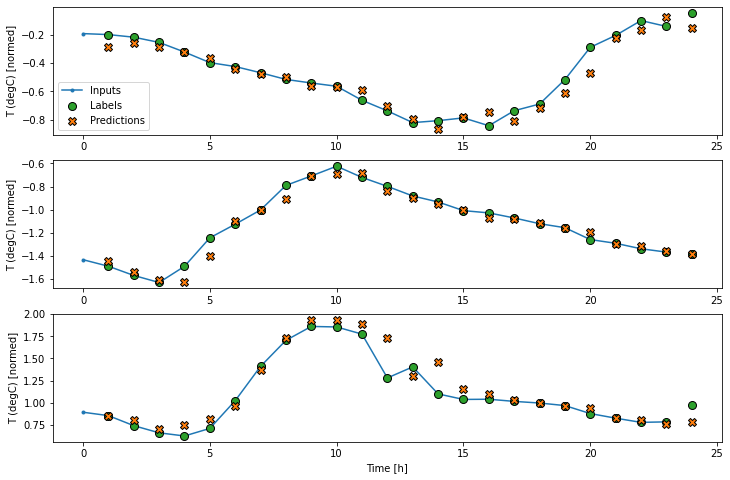

In [64]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it:

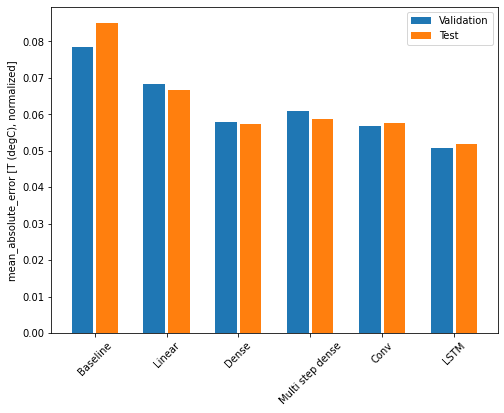

In [65]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [66]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0666
Dense       : 0.0573
Multi step dense: 0.0586
Conv        : 0.0577
LSTM        : 0.0518


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

In [67]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of `1`.

#### Baseline

The same baseline model (`Baseline`) can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [68]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [69]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 56s - loss: 0.0962 - mean_absolute_error: 0.1637

 28/438 [>.............................] - ETA: 0s - loss: 0.0911 - mean_absolute_error: 0.1608 

 55/438 [==>...........................] - ETA: 0s - loss: 0.0910 - mean_absolute_error: 0.1608

 82/438 [====>.........................] - ETA: 0s - loss: 0.0901 - mean_absolute_error: 0.1601

108/438 [======>.......................] - ETA: 0s - loss: 0.0901 - mean_absolute_error: 0.1601

135/438 [========>.....................] - ETA: 0s - loss: 0.0899 - mean_absolute_error: 0.1601

161/438 [==========>...................] - ETA: 0s - loss: 0.0897 - mean_absolute_error: 0.1599

188/438 [===========>..................] - ETA: 0s - loss: 0.0894 - mean_absolute_error: 0.1597

215/438 [=============>................] - ETA: 0s - loss: 0.0894 - mean_absolute_error: 0.1596

242/438 [===============>..............] - ETA: 0s - loss: 0.0890 - mean_absolute_error: 0.1593

268/438 [=================>............] - ETA: 0s - loss: 0.0888 - mean_absolute_error: 0.1591

294/438 [===================>..........] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1590

319/438 [====================>.........] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1591

346/438 [======================>.......] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

373/438 [========================>.....] - ETA: 0s - loss: 0.0883 - mean_absolute_error: 0.1589

401/438 [==========================>...] - ETA: 0s - loss: 0.0884 - mean_absolute_error: 0.1589

429/438 [============================>.] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1589

438/438 [==============================] - 1s 2ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense

In [70]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [71]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 25s - loss: 0.0962 - mean_absolute_error: 0.1488

 20/439 [>.............................] - ETA: 1s - loss: 0.0700 - mean_absolute_error: 0.1320 

 40/439 [=>............................] - ETA: 1s - loss: 0.0663 - mean_absolute_error: 0.1271

 60/439 [===>..........................] - ETA: 0s - loss: 0.0695 - mean_absolute_error: 0.1294

 79/439 [====>.........................] - ETA: 0s - loss: 0.0689 - mean_absolute_error: 0.1287

 99/439 [=====>........................] - ETA: 0s - loss: 0.0693 - mean_absolute_error: 0.1291

118/439 [=======>......................] - ETA: 0s - loss: 0.0693 - mean_absolute_error: 0.1293

137/439 [========>.....................] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1287

156/439 [=========>....................] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1285

176/439 [===========>..................] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1288

195/439 [============>.................] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1289

213/439 [=============>................] - ETA: 0s - loss: 0.0688 - mean_absolute_error: 0.1295

232/439 [==============>...............] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1290

251/439 [================>.............] - ETA: 0s - loss: 0.0684 - mean_absolute_error: 0.1294

271/439 [=================>............] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1292

290/439 [==================>...........] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1293

310/439 [====================>.........] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1292

328/439 [=====================>........] - ETA: 0s - loss: 0.0684 - mean_absolute_error: 0.1296

347/439 [======================>.......] - ETA: 0s - loss: 0.0690 - mean_absolute_error: 0.1302

367/439 [========================>.....] - ETA: 0s - loss: 0.0688 - mean_absolute_error: 0.1301

386/439 [=========================>....] - ETA: 0s - loss: 0.0688 - mean_absolute_error: 0.1303

405/439 [==========================>...] - ETA: 0s - loss: 0.0690 - mean_absolute_error: 0.1303

424/439 [===========================>..] - ETA: 0s - loss: 0.0688 - mean_absolute_error: 0.1301

439/439 [==============================] - 1s 3ms/step - loss: 0.0687 - mean_absolute_error: 0.1302


#### RNN


In [72]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

  1/438 [..............................] - ETA: 27s - loss: 0.0552 - mean_absolute_error: 0.1140

 18/438 [>.............................] - ETA: 1s - loss: 0.0635 - mean_absolute_error: 0.1211 

 36/438 [=>............................] - ETA: 1s - loss: 0.0627 - mean_absolute_error: 0.1211

 55/438 [==>...........................] - ETA: 1s - loss: 0.0619 - mean_absolute_error: 0.1203

 73/438 [====>.........................] - ETA: 1s - loss: 0.0616 - mean_absolute_error: 0.1202

 91/438 [=====>........................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1205

110/438 [======>.......................] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1202

128/438 [=======>......................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1207

146/438 [=========>....................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1207

164/438 [==========>...................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1206

183/438 [===========>..................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1208

201/438 [============>.................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1207

219/438 [==============>...............] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1207

237/438 [===============>..............] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1206

255/438 [================>.............] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1205

273/438 [=================>............] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1206

291/438 [==================>...........] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1206

309/438 [====================>.........] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1206

327/438 [=====================>........] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1206

346/438 [======================>.......] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1206

364/438 [=======================>......] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1206

383/438 [=========================>....] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1206

402/438 [==========================>...] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1205

421/438 [===========================>..] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1205

438/438 [==============================] - 1s 3ms/step - loss: 0.0617 - mean_absolute_error: 0.1205



CPU times: user 5min 14s, sys: 1min 17s, total: 6min 31s
Wall time: 2min 8s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [73]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [74]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 25s - loss: 0.0615 - mean_absolute_error: 0.1171

 19/438 [>.............................] - ETA: 1s - loss: 0.0600 - mean_absolute_error: 0.1158 

 36/438 [=>............................] - ETA: 1s - loss: 0.0607 - mean_absolute_error: 0.1164

 54/438 [==>...........................] - ETA: 1s - loss: 0.0612 - mean_absolute_error: 0.1169

 72/438 [===>..........................] - ETA: 1s - loss: 0.0613 - mean_absolute_error: 0.1167

 90/438 [=====>........................] - ETA: 1s - loss: 0.0616 - mean_absolute_error: 0.1171

108/438 [======>.......................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1174

125/438 [=======>......................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1177

143/438 [========>.....................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1177

160/438 [=========>....................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1179

178/438 [===========>..................] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1181

196/438 [============>.................] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.1183

214/438 [=============>................] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1180

232/438 [==============>...............] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1179

250/438 [================>.............] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1178

267/438 [=================>............] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1178

284/438 [==================>...........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1178

302/438 [===================>..........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1178

320/438 [====================>.........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1178

338/438 [======================>.......] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1176

356/438 [=======================>......] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1177

373/438 [========================>.....] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1177

390/438 [=========================>....] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1178

406/438 [==========================>...] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1179

423/438 [===========================>..] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1179

438/438 [==============================] - 1s 3ms/step - loss: 0.0620 - mean_absolute_error: 0.1179



CPU times: user 1min 43s, sys: 26.1 s, total: 2min 9s
Wall time: 43.1 s


#### Performance

Here is the overall performance for these multi-output models.

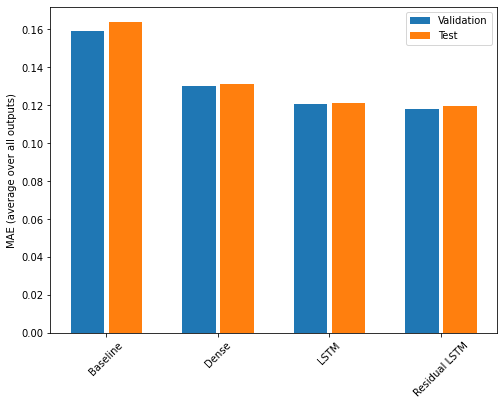

In [75]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [76]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1311
LSTM           : 0.1214
Residual LSTM  : 0.1194


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

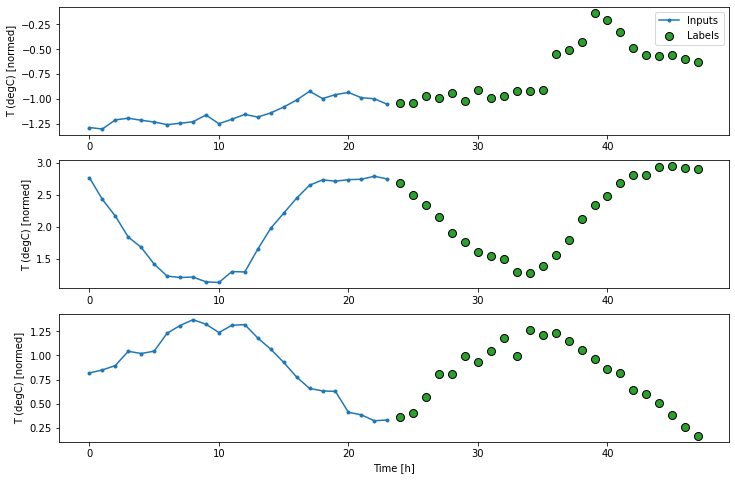

In [77]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](images/multistep_last.png)

  1/437 [..............................] - ETA: 1:09 - loss: 0.6220 - mean_absolute_error: 0.5048

 26/437 [>.............................] - ETA: 0s - loss: 0.6230 - mean_absolute_error: 0.4986  

 53/437 [==>...........................] - ETA: 0s - loss: 0.6252 - mean_absolute_error: 0.5005

 80/437 [====>.........................] - ETA: 0s - loss: 0.6288 - mean_absolute_error: 0.5013

106/437 [======>.......................] - ETA: 0s - loss: 0.6261 - mean_absolute_error: 0.4998

133/437 [========>.....................] - ETA: 0s - loss: 0.6290 - mean_absolute_error: 0.5017

159/437 [=========>....................] - ETA: 0s - loss: 0.6302 - mean_absolute_error: 0.5026

185/437 [===========>..................] - ETA: 0s - loss: 0.6281 - mean_absolute_error: 0.5015

212/437 [=============>................] - ETA: 0s - loss: 0.6276 - mean_absolute_error: 0.5009

237/437 [===============>..............] - ETA: 0s - loss: 0.6253 - mean_absolute_error: 0.4998

260/437 [================>.............] - ETA: 0s - loss: 0.6257 - mean_absolute_error: 0.4998

287/437 [==================>...........] - ETA: 0s - loss: 0.6258 - mean_absolute_error: 0.4995

314/437 [====================>.........] - ETA: 0s - loss: 0.6270 - mean_absolute_error: 0.5000

341/437 [======================>.......] - ETA: 0s - loss: 0.6277 - mean_absolute_error: 0.5003

368/437 [========================>.....] - ETA: 0s - loss: 0.6286 - mean_absolute_error: 0.5007

396/437 [==========================>...] - ETA: 0s - loss: 0.6281 - mean_absolute_error: 0.5005

422/437 [===========================>..] - ETA: 0s - loss: 0.6279 - mean_absolute_error: 0.5004

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


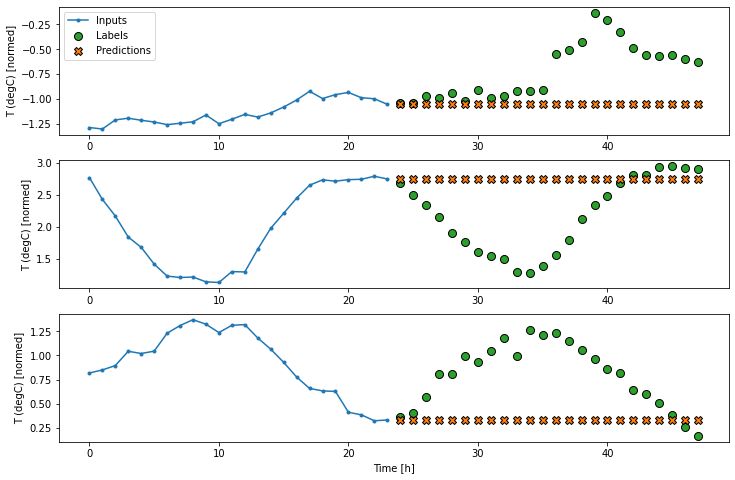

In [78]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24 hours into the future, given 24 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 1:02 - loss: 0.4019 - mean_absolute_error: 0.3839

 27/437 [>.............................] - ETA: 0s - loss: 0.4322 - mean_absolute_error: 0.3942  

 54/437 [==>...........................] - ETA: 0s - loss: 0.4313 - mean_absolute_error: 0.3967

 81/437 [====>.........................] - ETA: 0s - loss: 0.4302 - mean_absolute_error: 0.3961

104/437 [======>.......................] - ETA: 0s - loss: 0.4334 - mean_absolute_error: 0.3974

131/437 [=======>......................] - ETA: 0s - loss: 0.4327 - mean_absolute_error: 0.3975

158/437 [=========>....................] - ETA: 0s - loss: 0.4311 - mean_absolute_error: 0.3967

184/437 [===========>..................] - ETA: 0s - loss: 0.4296 - mean_absolute_error: 0.3964

210/437 [=============>................] - ETA: 0s - loss: 0.4298 - mean_absolute_error: 0.3966

237/437 [===============>..............] - ETA: 0s - loss: 0.4297 - mean_absolute_error: 0.3966

263/437 [=================>............] - ETA: 0s - loss: 0.4282 - mean_absolute_error: 0.3959

290/437 [==================>...........] - ETA: 0s - loss: 0.4289 - mean_absolute_error: 0.3961

317/437 [====================>.........] - ETA: 0s - loss: 0.4282 - mean_absolute_error: 0.3961

344/437 [======================>.......] - ETA: 0s - loss: 0.4289 - mean_absolute_error: 0.3964

371/437 [========================>.....] - ETA: 0s - loss: 0.4279 - mean_absolute_error: 0.3962

398/437 [==========================>...] - ETA: 0s - loss: 0.4271 - mean_absolute_error: 0.3959

424/437 [============================>.] - ETA: 0s - loss: 0.4271 - mean_absolute_error: 0.3959

437/437 [==============================] - 1s 2ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


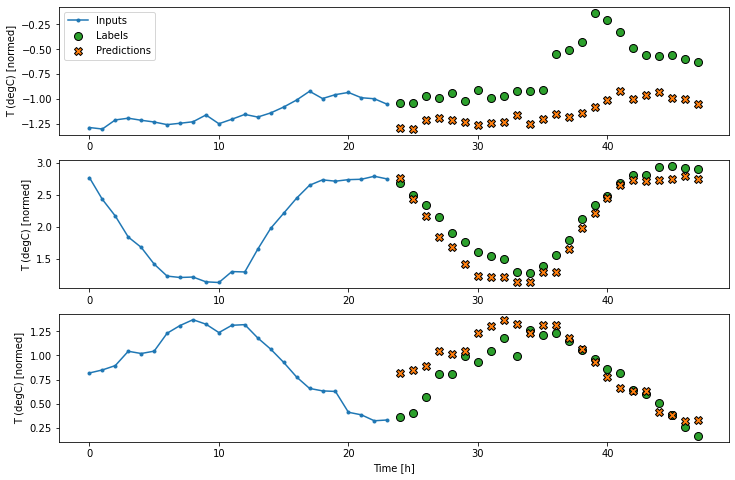

In [79]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](images/multistep_dense.png)

  1/437 [..............................] - ETA: 25s - loss: 0.2533 - mean_absolute_error: 0.3028

 24/437 [>.............................] - ETA: 0s - loss: 0.2581 - mean_absolute_error: 0.3073 

 48/437 [==>...........................] - ETA: 0s - loss: 0.2553 - mean_absolute_error: 0.3053

 72/437 [===>..........................] - ETA: 0s - loss: 0.2540 - mean_absolute_error: 0.3043

 96/437 [=====>........................] - ETA: 0s - loss: 0.2529 - mean_absolute_error: 0.3043

120/437 [=======>......................] - ETA: 0s - loss: 0.2534 - mean_absolute_error: 0.3047

144/437 [========>.....................] - ETA: 0s - loss: 0.2540 - mean_absolute_error: 0.3049

168/437 [==========>...................] - ETA: 0s - loss: 0.2549 - mean_absolute_error: 0.3055

192/437 [============>.................] - ETA: 0s - loss: 0.2544 - mean_absolute_error: 0.3050

216/437 [=============>................] - ETA: 0s - loss: 0.2552 - mean_absolute_error: 0.3051

240/437 [===============>..............] - ETA: 0s - loss: 0.2549 - mean_absolute_error: 0.3050

263/437 [=================>............] - ETA: 0s - loss: 0.2555 - mean_absolute_error: 0.3053

287/437 [==================>...........] - ETA: 0s - loss: 0.2563 - mean_absolute_error: 0.3056

311/437 [====================>.........] - ETA: 0s - loss: 0.2563 - mean_absolute_error: 0.3056

335/437 [=====================>........] - ETA: 0s - loss: 0.2559 - mean_absolute_error: 0.3053

359/437 [=======================>......] - ETA: 0s - loss: 0.2560 - mean_absolute_error: 0.3054

383/437 [=========================>....] - ETA: 0s - loss: 0.2558 - mean_absolute_error: 0.3053

406/437 [==========================>...] - ETA: 0s - loss: 0.2563 - mean_absolute_error: 0.3055

429/437 [============================>.] - ETA: 0s - loss: 0.2559 - mean_absolute_error: 0.3054

437/437 [==============================] - 1s 2ms/step - loss: 0.2559 - mean_absolute_error: 0.3053


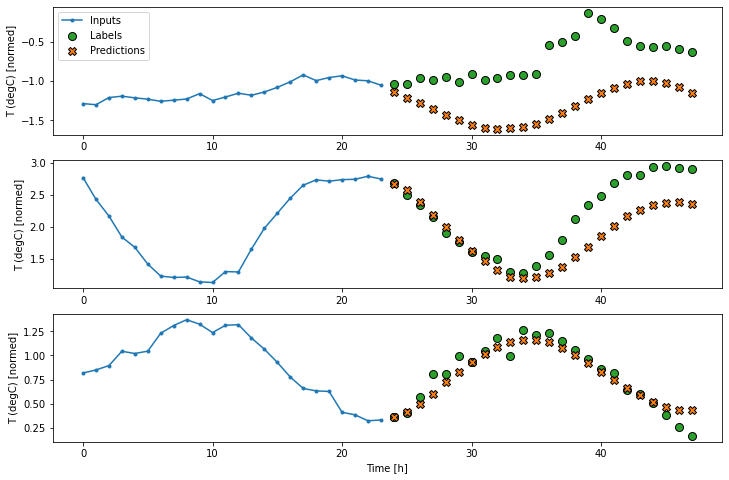

In [80]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

  1/437 [..............................] - ETA: 25s - loss: 0.1910 - mean_absolute_error: 0.2634

 20/437 [>.............................] - ETA: 1s - loss: 0.2172 - mean_absolute_error: 0.2830 

 40/437 [=>............................] - ETA: 1s - loss: 0.2175 - mean_absolute_error: 0.2830

 59/437 [===>..........................] - ETA: 1s - loss: 0.2164 - mean_absolute_error: 0.2822

 77/437 [====>.........................] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2823

 95/437 [=====>........................] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2822

115/437 [======>.......................] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2824

135/437 [========>.....................] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2817

154/437 [=========>....................] - ETA: 0s - loss: 0.2164 - mean_absolute_error: 0.2822

173/437 [==========>...................] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2825

192/437 [============>.................] - ETA: 0s - loss: 0.2182 - mean_absolute_error: 0.2831

211/437 [=============>................] - ETA: 0s - loss: 0.2191 - mean_absolute_error: 0.2835

231/437 [==============>...............] - ETA: 0s - loss: 0.2194 - mean_absolute_error: 0.2836

251/437 [================>.............] - ETA: 0s - loss: 0.2194 - mean_absolute_error: 0.2835

271/437 [=================>............] - ETA: 0s - loss: 0.2200 - mean_absolute_error: 0.2837

291/437 [==================>...........] - ETA: 0s - loss: 0.2205 - mean_absolute_error: 0.2837

311/437 [====================>.........] - ETA: 0s - loss: 0.2207 - mean_absolute_error: 0.2838

331/437 [=====================>........] - ETA: 0s - loss: 0.2207 - mean_absolute_error: 0.2838

351/437 [=======================>......] - ETA: 0s - loss: 0.2201 - mean_absolute_error: 0.2835

371/437 [========================>.....] - ETA: 0s - loss: 0.2201 - mean_absolute_error: 0.2836

391/437 [=========================>....] - ETA: 0s - loss: 0.2199 - mean_absolute_error: 0.2834

411/437 [===========================>..] - ETA: 0s - loss: 0.2200 - mean_absolute_error: 0.2835

432/437 [============================>.] - ETA: 0s - loss: 0.2207 - mean_absolute_error: 0.2838

437/437 [==============================] - 1s 3ms/step - loss: 0.2205 - mean_absolute_error: 0.2837


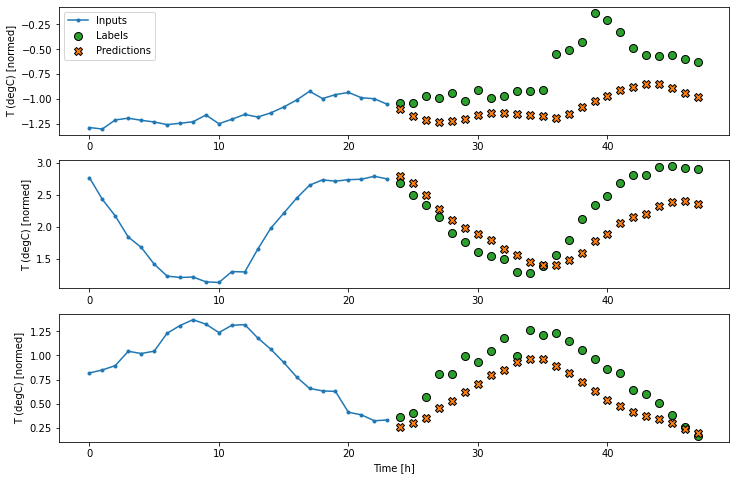

In [81]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

  1/437 [..............................] - ETA: 24s - loss: 0.1847 - mean_absolute_error: 0.2538

 21/437 [>.............................] - ETA: 1s - loss: 0.2116 - mean_absolute_error: 0.2822 

 42/437 [=>............................] - ETA: 0s - loss: 0.2121 - mean_absolute_error: 0.2819

 64/437 [===>..........................] - ETA: 0s - loss: 0.2127 - mean_absolute_error: 0.2825

 85/437 [====>.........................] - ETA: 0s - loss: 0.2100 - mean_absolute_error: 0.2807

107/437 [======>.......................] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2830

128/437 [=======>......................] - ETA: 0s - loss: 0.2153 - mean_absolute_error: 0.2839

149/437 [=========>....................] - ETA: 0s - loss: 0.2148 - mean_absolute_error: 0.2838

171/437 [==========>...................] - ETA: 0s - loss: 0.2154 - mean_absolute_error: 0.2837

193/437 [============>.................] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2837

215/437 [=============>................] - ETA: 0s - loss: 0.2151 - mean_absolute_error: 0.2833

236/437 [===============>..............] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2831

258/437 [================>.............] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2829

279/437 [==================>...........] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2829

301/437 [===================>..........] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2825

322/437 [=====================>........] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2826

342/437 [======================>.......] - ETA: 0s - loss: 0.2149 - mean_absolute_error: 0.2829

363/437 [=======================>......] - ETA: 0s - loss: 0.2155 - mean_absolute_error: 0.2832

384/437 [=========================>....] - ETA: 0s - loss: 0.2153 - mean_absolute_error: 0.2831

406/437 [==========================>...] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2833

426/437 [============================>.] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2833

437/437 [==============================] - 1s 2ms/step - loss: 0.2158 - mean_absolute_error: 0.2833


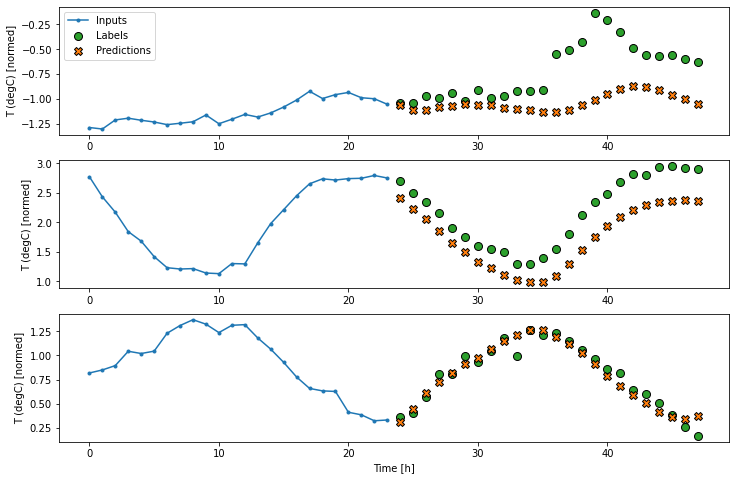

In [82]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](images/multistep_lstm.png)


  1/437 [..............................] - ETA: 24s - loss: 0.2179 - mean_absolute_error: 0.2954

 20/437 [>.............................] - ETA: 1s - loss: 0.2217 - mean_absolute_error: 0.2901 

 41/437 [=>............................] - ETA: 1s - loss: 0.2197 - mean_absolute_error: 0.2889

 61/437 [===>..........................] - ETA: 0s - loss: 0.2143 - mean_absolute_error: 0.2855

 81/437 [====>.........................] - ETA: 0s - loss: 0.2152 - mean_absolute_error: 0.2860

102/437 [======>.......................] - ETA: 0s - loss: 0.2134 - mean_absolute_error: 0.2854

123/437 [=======>......................] - ETA: 0s - loss: 0.2132 - mean_absolute_error: 0.2854

144/437 [========>.....................] - ETA: 0s - loss: 0.2135 - mean_absolute_error: 0.2854

165/437 [==========>...................] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2854

185/437 [===========>..................] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2856

206/437 [=============>................] - ETA: 0s - loss: 0.2153 - mean_absolute_error: 0.2861

227/437 [==============>...............] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2863

247/437 [===============>..............] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2863

267/437 [=================>............] - ETA: 0s - loss: 0.2162 - mean_absolute_error: 0.2864

286/437 [==================>...........] - ETA: 0s - loss: 0.2162 - mean_absolute_error: 0.2865

305/437 [===================>..........] - ETA: 0s - loss: 0.2164 - mean_absolute_error: 0.2865

325/437 [=====================>........] - ETA: 0s - loss: 0.2159 - mean_absolute_error: 0.2864

346/437 [======================>.......] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2864

366/437 [========================>.....] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2861

386/437 [=========================>....] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2861

405/437 [==========================>...] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2862

424/437 [============================>.] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2861

437/437 [==============================] - 1s 3ms/step - loss: 0.2159 - mean_absolute_error: 0.2863


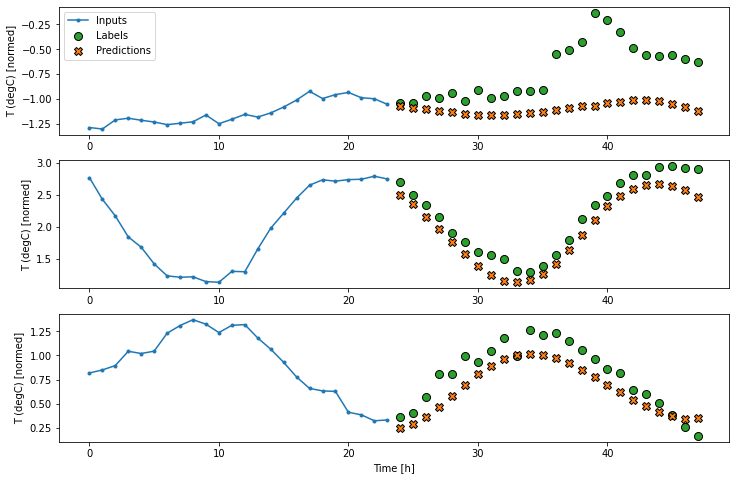

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [84]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [86]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [88]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [89]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now, train the model:

  1/437 [..............................] - ETA: 27s - loss: 0.2313 - mean_absolute_error: 0.3106

  7/437 [..............................] - ETA: 3s - loss: 0.2233 - mean_absolute_error: 0.3021 

 14/437 [..............................] - ETA: 3s - loss: 0.2249 - mean_absolute_error: 0.3024

 21/437 [>.............................] - ETA: 3s - loss: 0.2265 - mean_absolute_error: 0.3021

 28/437 [>.............................] - ETA: 3s - loss: 0.2266 - mean_absolute_error: 0.3020

 35/437 [=>............................] - ETA: 3s - loss: 0.2242 - mean_absolute_error: 0.2999

 42/437 [=>............................] - ETA: 2s - loss: 0.2241 - mean_absolute_error: 0.2994

 49/437 [==>...........................] - ETA: 2s - loss: 0.2221 - mean_absolute_error: 0.2985

 56/437 [==>...........................] - ETA: 2s - loss: 0.2227 - mean_absolute_error: 0.2993

 63/437 [===>..........................] - ETA: 2s - loss: 0.2219 - mean_absolute_error: 0.2986

 70/437 [===>..........................] - ETA: 2s - loss: 0.2218 - mean_absolute_error: 0.2985

 76/437 [====>.........................] - ETA: 2s - loss: 0.2233 - mean_absolute_error: 0.2998

 83/437 [====>.........................] - ETA: 2s - loss: 0.2232 - mean_absolute_error: 0.2998

 90/437 [=====>........................] - ETA: 2s - loss: 0.2238 - mean_absolute_error: 0.3003

 96/437 [=====>........................] - ETA: 2s - loss: 0.2243 - mean_absolute_error: 0.3005

102/437 [======>.......................] - ETA: 2s - loss: 0.2245 - mean_absolute_error: 0.3007

109/437 [======>.......................] - ETA: 2s - loss: 0.2246 - mean_absolute_error: 0.3006

115/437 [======>.......................] - ETA: 2s - loss: 0.2255 - mean_absolute_error: 0.3013

122/437 [=======>......................] - ETA: 2s - loss: 0.2264 - mean_absolute_error: 0.3013

129/437 [=======>......................] - ETA: 2s - loss: 0.2280 - mean_absolute_error: 0.3024

136/437 [========>.....................] - ETA: 2s - loss: 0.2277 - mean_absolute_error: 0.3024

143/437 [========>.....................] - ETA: 2s - loss: 0.2268 - mean_absolute_error: 0.3019

150/437 [=========>....................] - ETA: 2s - loss: 0.2263 - mean_absolute_error: 0.3017

157/437 [=========>....................] - ETA: 2s - loss: 0.2264 - mean_absolute_error: 0.3015

164/437 [==========>...................] - ETA: 2s - loss: 0.2262 - mean_absolute_error: 0.3014

171/437 [==========>...................] - ETA: 2s - loss: 0.2262 - mean_absolute_error: 0.3015

178/437 [===========>..................] - ETA: 2s - loss: 0.2256 - mean_absolute_error: 0.3012

185/437 [===========>..................] - ETA: 1s - loss: 0.2252 - mean_absolute_error: 0.3008

192/437 [============>.................] - ETA: 1s - loss: 0.2256 - mean_absolute_error: 0.3009

198/437 [============>.................] - ETA: 1s - loss: 0.2258 - mean_absolute_error: 0.3010

205/437 [=============>................] - ETA: 1s - loss: 0.2264 - mean_absolute_error: 0.3013

212/437 [=============>................] - ETA: 1s - loss: 0.2268 - mean_absolute_error: 0.3014

219/437 [==============>...............] - ETA: 1s - loss: 0.2265 - mean_absolute_error: 0.3012

226/437 [==============>...............] - ETA: 1s - loss: 0.2265 - mean_absolute_error: 0.3012

233/437 [==============>...............] - ETA: 1s - loss: 0.2260 - mean_absolute_error: 0.3009

240/437 [===============>..............] - ETA: 1s - loss: 0.2260 - mean_absolute_error: 0.3009

247/437 [===============>..............] - ETA: 1s - loss: 0.2262 - mean_absolute_error: 0.3011

254/437 [================>.............] - ETA: 1s - loss: 0.2261 - mean_absolute_error: 0.3011

261/437 [================>.............] - ETA: 1s - loss: 0.2261 - mean_absolute_error: 0.3010

268/437 [=================>............] - ETA: 1s - loss: 0.2265 - mean_absolute_error: 0.3013

275/437 [=================>............] - ETA: 1s - loss: 0.2262 - mean_absolute_error: 0.3011

282/437 [==================>...........] - ETA: 1s - loss: 0.2263 - mean_absolute_error: 0.3011

289/437 [==================>...........] - ETA: 1s - loss: 0.2261 - mean_absolute_error: 0.3011

296/437 [===================>..........] - ETA: 1s - loss: 0.2266 - mean_absolute_error: 0.3014

303/437 [===================>..........] - ETA: 1s - loss: 0.2264 - mean_absolute_error: 0.3012

310/437 [====================>.........] - ETA: 0s - loss: 0.2265 - mean_absolute_error: 0.3011

317/437 [====================>.........] - ETA: 0s - loss: 0.2265 - mean_absolute_error: 0.3012

324/437 [=====================>........] - ETA: 0s - loss: 0.2265 - mean_absolute_error: 0.3011

331/437 [=====================>........] - ETA: 0s - loss: 0.2265 - mean_absolute_error: 0.3011

338/437 [======================>.......] - ETA: 0s - loss: 0.2267 - mean_absolute_error: 0.3011

345/437 [======================>.......] - ETA: 0s - loss: 0.2266 - mean_absolute_error: 0.3011

352/437 [=======================>......] - ETA: 0s - loss: 0.2267 - mean_absolute_error: 0.3011

359/437 [=======================>......] - ETA: 0s - loss: 0.2266 - mean_absolute_error: 0.3011

366/437 [========================>.....] - ETA: 0s - loss: 0.2266 - mean_absolute_error: 0.3010

373/437 [========================>.....] - ETA: 0s - loss: 0.2267 - mean_absolute_error: 0.3010

380/437 [=========================>....] - ETA: 0s - loss: 0.2267 - mean_absolute_error: 0.3011

387/437 [=========================>....] - ETA: 0s - loss: 0.2268 - mean_absolute_error: 0.3011

394/437 [==========================>...] - ETA: 0s - loss: 0.2268 - mean_absolute_error: 0.3011

401/437 [==========================>...] - ETA: 0s - loss: 0.2268 - mean_absolute_error: 0.3011

408/437 [===========================>..] - ETA: 0s - loss: 0.2267 - mean_absolute_error: 0.3010

415/437 [===========================>..] - ETA: 0s - loss: 0.2268 - mean_absolute_error: 0.3010

422/437 [===========================>..] - ETA: 0s - loss: 0.2268 - mean_absolute_error: 0.3009

429/437 [============================>.] - ETA: 0s - loss: 0.2266 - mean_absolute_error: 0.3009

437/437 [==============================] - ETA: 0s - loss: 0.2269 - mean_absolute_error: 0.3011

437/437 [==============================] - 3s 8ms/step - loss: 0.2269 - mean_absolute_error: 0.3011


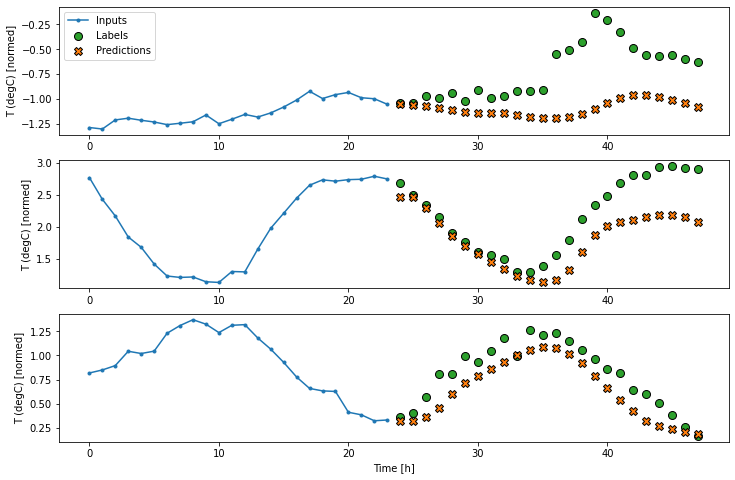

In [90]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem:

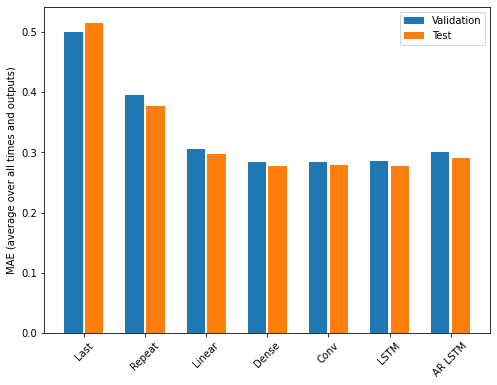

In [91]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps. 

In [92]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2977
Dense   : 0.2781
Conv    : 0.2796
LSTM    : 0.2767
AR LSTM : 0.2901


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

To learn more, refer to:

- Chapter 15 of <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>, 2nd Edition.
- Chapter 6 of <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.
- Lesson 8 of <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity's intro to TensorFlow for deep learning</a>, including the <a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">exercise notebooks</a>.

Also, remember that you can implement any <a href="https://otexts.com/fpp2/index.html" class="external">classical time series model</a> in TensorFlow—this tutorial just focuses on TensorFlow's built-in functionality.
